In [175]:
import os
import zipfile
import pathlib
import json
import shutil
import tempfile
import time
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    Activations,
    Activationsd,
    AsDiscrete,
    AsDiscreted,
    LoadImaged,
    Compose,
    EnsureChannelFirstd,
    Orientationd,
    Spacingd,
    RandSpatialCropd,
    RandFlipd,
    NormalizeIntensityd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    EnsureTyped,
    MapTransform,
    EnsureType,
    Invertd
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR, SegResNet
from monai.data import (
    DataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch
)
from functools import partial

import torch


print_config()

MONAI version: 0.9.0
Numpy version: 1.22.4
Pytorch version: 1.11.0+cu113
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: af0e0e9f757558d144b655c63afcea3a4e0a06f5
MONAI __file__: /home/jovyan/.local/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 4.0.1
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.9.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0+cu113
tqdm version: 4.64.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.1
pandas version: 1.4.2
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-de

In [2]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version
# Check GPU-availability

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 9.3.0-17ubuntu1~20.04) 9.3.0
Copyright (C) 2019 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
!nvidia-smi -L
!nvidia-smi

GPU 0: NVIDIA A100-PCIE-40GB (UUID: GPU-58e6b591-fda2-1ecc-f6c6-9a1ac8c4cd33)
GPU 1: NVIDIA A100-PCIE-40GB (UUID: GPU-6b2e87f8-0094-f585-3b13-7b2817bc52c8)
GPU 2: NVIDIA A100-PCIE-40GB (UUID: GPU-9db3ff93-0cb9-384c-f1df-dedcd47f66ab)
Tue Jun 28 12:34:40 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  On   | 00000000:01:00.0 Off |                    0 |
| N/A   30C    P0    34W / 250W |     35MiB / 40960MiB |      0%      Default |
|             

# Setup data directory

In [4]:
directory = os.path.join(os.getcwd(), 'data', 'monai')
print("Monai Directory exists:", os.path.isdir(directory))
root_dir = tempfile.mkdtemp() if directory is None else directory
print("located at:", root_dir)

Monai Directory exists: True
located at: /home/jovyan/HK_DV/data/monai


# Setup transforms and dataloader for training and validation
#### ConvertToMultiChannel BasedOnBratsClassed is a new transform thats splits each label in a seperate channel

In [166]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Split labels to multi channels
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            result.append(d[key] == 1)
            result.append(d[key] == 2)
            result.append(d[key] == 3)
            d[key] = np.stack(result, axis=0).astype(np.float32)
        return d
        
def get_loader(batch_size, data_dir, json_list, roi):
    data_dir = data_dir
    datalist_json = json_list
    
    train_files = load_decathlon_datalist(datalist_json, True, "training")
    validation_files = load_decathlon_datalist(datalist_json, True, "validation")
    
    train_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys="image"),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.0, 1.0, 1.0),
                mode=("bilinear", "nearest"),
            ),
            RandSpatialCropd(
                keys=["image", "label"],
                roi_size=[roi[0], roi[1], roi[2]],
                random_size=False,
            ),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
            RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
            NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
            RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
            EnsureTyped(keys=["image", "label"]),
        ]
    )
    val_transform = Compose(
        [
            LoadImaged(keys=["image", "label"]),
            EnsureChannelFirstd(keys="image"),
            ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
            Orientationd(keys=["image", "label"], axcodes="RAS"),
            Spacingd(
                keys=["image", "label"],
                pixdim=(1.0, 1.0, 1.0),
                mode=("bilinear", "nearest"),
            ),
            NormalizeIntensityd(
                keys="image", nonzero=True, channel_wise=True
            ),
            EnsureTyped(keys=["image", "label"]),
        ]
    )

    train_ds = CacheDataset(
        data=train_files,
        transform=train_transform,
        cache_num=8,
        cache_rate=1,
        num_workers=8,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
    )

    val_ds = CacheDataset(
        data=validation_files, 
        transform=val_transform, 
        cache_num=1, 
        cache_rate=1.0, 
        num_workers=2
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=1,
        shuffle=False,
        num_workers=0,
        pin_memory=True,
    )

    return train_loader, val_loader, train_ds, val_ds

In [168]:
data_dir = os.path.join(os.getcwd(), 'data', 'Task01_BrainTumour')
if(os.path.isdir(data_dir)):
    f = open(os.path.join(data_dir, 'dataset.json'))
    dataset = json.load(f)
    f.close()

    print(dataset["labels"])

    split_JSON = "dataset.json"

    json_list = os.path.join(data_dir, split_JSON)

    num_labels = len(dataset["labels"])
    roi = [224, 224, 144]
    batch_size = 2
    sw_batch_size = 2

    train_loader, val_loader, train_ds, val_ds = get_loader(batch_size, data_dir, json_list, roi)

{'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}


Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.20it/s]


In [61]:
dataset

{'name': 'BRATS',
 'description': 'Gliomas segmentation tumour and oedema in on brain images',
 'reference': 'https://www.med.upenn.edu/sbia/brats2017.html',
 'licence': 'CC-BY-SA 4.0',
 'release': '2.0 04/05/2018',
 'tensorImageSize': '4D',
 'modality': {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'},
 'labels': {'0': 'background',
  '1': 'edema',
  '2': 'non-enhancing tumor',
  '3': 'enhancing tumour'},
 'numTraining': 484,
 'numTest': 266,
 'training': [{'image': './imagesTr/BRATS_457.nii.gz',
   'label': './labelsTr/BRATS_457.nii.gz'},
  {'image': './imagesTr/BRATS_306.nii.gz',
   'label': './labelsTr/BRATS_306.nii.gz'},
  {'image': './imagesTr/BRATS_206.nii.gz',
   'label': './labelsTr/BRATS_206.nii.gz'},
  {'image': './imagesTr/BRATS_449.nii.gz',
   'label': './labelsTr/BRATS_449.nii.gz'},
  {'image': './imagesTr/BRATS_318.nii.gz',
   'label': './labelsTr/BRATS_318.nii.gz'},
  {'image': './imagesTr/BRATS_218.nii.gz',
   'label': './labelsTr/BRATS_218.nii.gz'},
  {'image': './

In [62]:
print("Anzahl Traingingsdaten:", len(dataset["training"]))
print("Anzahl Validationsdaten:", len(dataset["validation"]))
print("Anzahl Testdaten:", len(dataset["test"]))
print("Summe:", len(dataset["training"]) + len(dataset["validation"]) + len(dataset["test"]))

Anzahl Traingingsdaten: 236
Anzahl Validationsdaten: 68
Anzahl Testdaten: 34
Summe: 338


# Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


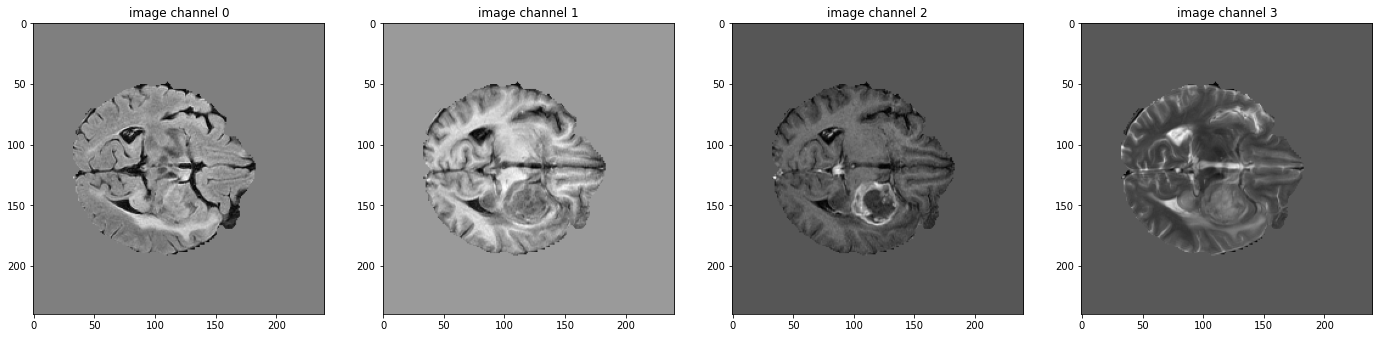

label shape: torch.Size([3, 240, 240, 155])


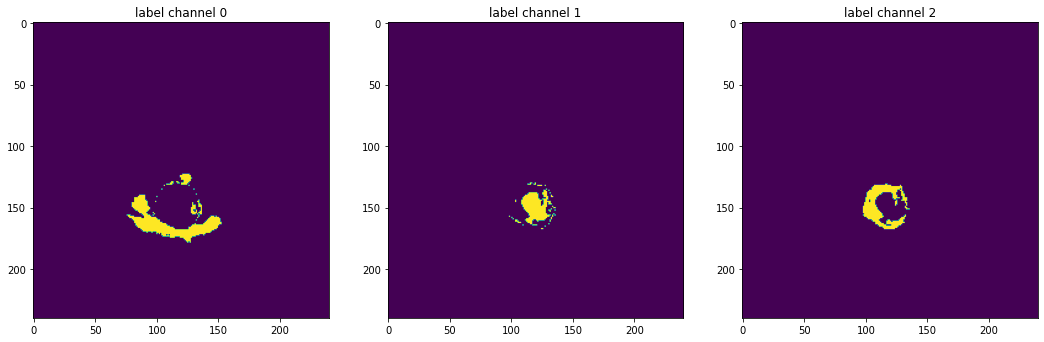

In [58]:
# pick one image from DecathlonDataset to visualize and check the 4 channels
val_data_example = val_ds[2]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(4):
    plt.subplot(1, 4, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, 60].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this image
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, 60].detach().cpu())
plt.show()

# Create Model

In [8]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

cuda:1


### load model if necessary

In [9]:
# checkpoint = torch.load(os.path.join(root_dir, "best_metric_model_new.pth"))
# print(checkpoint)
# model.load_state_dict(checkpoint)
# model.to(device)

In [10]:
# use amp to accelerate training
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
torch.backends.cudnn.benchmark = True

max_epochs = 239
val_interval = 1
VAL_AMP = True

loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

post_trans = Compose(
    [EnsureType(), Activations(sigmoid=True), AsDiscrete(threshold=0.5)]
)

In [11]:
# define inference method
def inference(input):

    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP:
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:
        return _compute(input)

# Execute training process

In [12]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []

total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():

            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(root_dir, "best_metric_model_new.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" edema: {metric_tc:.4f} non-enhancing tumor: {metric_wt:.4f} enhancing tumour: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/239
1/118, train_loss: 0.9862, step time: 14.7850
2/118, train_loss: 0.9707, step time: 0.5639
3/118, train_loss: 0.9662, step time: 0.5533
4/118, train_loss: 0.9457, step time: 0.5870
5/118, train_loss: 0.9665, step time: 0.5562
6/118, train_loss: 0.9933, step time: 0.5963
7/118, train_loss: 0.9762, step time: 0.5529
8/118, train_loss: 0.9470, step time: 0.5894
9/118, train_loss: 0.9480, step time: 0.5858
10/118, train_loss: 0.9506, step time: 0.5714
11/118, train_loss: 0.9462, step time: 0.5515
12/118, train_loss: 0.9231, step time: 0.5730
13/118, train_loss: 0.9223, step time: 0.5740
14/118, train_loss: 0.9315, step time: 0.5679
15/118, train_loss: 0.9704, step time: 0.5466
16/118, train_loss: 0.9925, step time: 0.5830
17/118, train_loss: 0.9783, step time: 0.5512
18/118, train_loss: 0.9527, step time: 0.5914
19/118, train_loss: 0.9599, step time: 0.5938
20/118, train_loss: 0.9593, step time: 0.5738
21/118, train_loss: 0.9567, step time: 0.5616
22/118, train_loss:

74/118, train_loss: 0.9607, step time: 0.5538
75/118, train_loss: 0.9659, step time: 0.5763
76/118, train_loss: 0.9499, step time: 0.5891
77/118, train_loss: 0.9312, step time: 0.5909
78/118, train_loss: 0.9666, step time: 0.5926
79/118, train_loss: 0.9044, step time: 0.5720
80/118, train_loss: 0.9747, step time: 0.5608
81/118, train_loss: 0.9319, step time: 0.5723
82/118, train_loss: 0.9582, step time: 0.5528
83/118, train_loss: 0.9610, step time: 0.5550
84/118, train_loss: 0.9255, step time: 0.5627
85/118, train_loss: 0.9525, step time: 0.5514
86/118, train_loss: 0.9545, step time: 0.5861
87/118, train_loss: 0.9853, step time: 0.5537
88/118, train_loss: 0.9488, step time: 0.5505
89/118, train_loss: 0.9535, step time: 0.5701
90/118, train_loss: 0.9401, step time: 0.5050
91/118, train_loss: 0.9312, step time: 0.5558
92/118, train_loss: 0.9591, step time: 0.5655
93/118, train_loss: 0.9253, step time: 0.5540
94/118, train_loss: 0.9308, step time: 0.5905
95/118, train_loss: 0.9866, step t

6/118, train_loss: 0.9590, step time: 0.5806
7/118, train_loss: 0.9128, step time: 0.5703
8/118, train_loss: 0.9470, step time: 0.5939
9/118, train_loss: 0.9517, step time: 0.5697
10/118, train_loss: 0.9734, step time: 0.5756
11/118, train_loss: 0.9498, step time: 0.5535
12/118, train_loss: 0.9376, step time: 0.5729
13/118, train_loss: 0.9230, step time: 0.4998
14/118, train_loss: 0.9174, step time: 0.5928
15/118, train_loss: 0.9720, step time: 0.5694
16/118, train_loss: 0.9600, step time: 0.5522
17/118, train_loss: 0.9354, step time: 0.5962
18/118, train_loss: 0.9117, step time: 0.5823
19/118, train_loss: 0.9582, step time: 0.5472
20/118, train_loss: 0.9036, step time: 0.5832
21/118, train_loss: 0.9613, step time: 0.5541
22/118, train_loss: 0.9478, step time: 0.5679
23/118, train_loss: 0.9472, step time: 0.5556
24/118, train_loss: 0.9582, step time: 0.5906
25/118, train_loss: 0.9452, step time: 0.5715
26/118, train_loss: 0.9625, step time: 0.5937
27/118, train_loss: 0.9534, step time:

61/118, train_loss: 0.9229, step time: 0.5902
62/118, train_loss: 0.9180, step time: 0.5041
63/118, train_loss: 0.9341, step time: 0.5693
64/118, train_loss: 0.9122, step time: 0.5962
65/118, train_loss: 0.9256, step time: 0.5715
66/118, train_loss: 0.8976, step time: 0.5741
67/118, train_loss: 0.8952, step time: 0.5613
68/118, train_loss: 0.9356, step time: 0.5754
69/118, train_loss: 0.9282, step time: 0.5725
70/118, train_loss: 0.9065, step time: 0.5788
71/118, train_loss: 0.9357, step time: 0.5920
72/118, train_loss: 0.9148, step time: 0.5723
73/118, train_loss: 0.9518, step time: 0.5550
74/118, train_loss: 0.9510, step time: 0.5626
75/118, train_loss: 0.9672, step time: 0.5875
76/118, train_loss: 0.9198, step time: 0.5743
77/118, train_loss: 0.9208, step time: 0.5969
78/118, train_loss: 0.9223, step time: 0.5868
79/118, train_loss: 0.9272, step time: 0.5615
80/118, train_loss: 0.9382, step time: 0.5910
81/118, train_loss: 0.9169, step time: 0.5916
82/118, train_loss: 0.8930, step t

116/118, train_loss: 0.9162, step time: 0.5966
117/118, train_loss: 0.9267, step time: 0.5273
118/118, train_loss: 0.8729, step time: 0.5708
epoch 6 average loss: 0.9111
current epoch: 6 current mean dice: 0.2094 tc: 0.4340 wt: 0.0045 et: 0.1949
best mean dice: 0.2392 at epoch: 5
time consuming of epoch 6 is: 369.5234
----------
epoch 7/239
1/118, train_loss: 0.8921, step time: 0.5684
2/118, train_loss: 0.9106, step time: 0.5706
3/118, train_loss: 0.9228, step time: 0.5003
4/118, train_loss: 0.9135, step time: 0.6000
5/118, train_loss: 0.8813, step time: 0.5321
6/118, train_loss: 0.9299, step time: 0.5606
7/118, train_loss: 0.9061, step time: 0.5618
8/118, train_loss: 0.9067, step time: 0.5662
9/118, train_loss: 0.9814, step time: 0.5713
10/118, train_loss: 0.9029, step time: 0.5642
11/118, train_loss: 0.8689, step time: 0.5857
12/118, train_loss: 0.8399, step time: 0.5672
13/118, train_loss: 0.9027, step time: 0.5526
14/118, train_loss: 0.8951, step time: 0.5823
15/118, train_loss: 0.

49/118, train_loss: 0.8225, step time: 0.5552
50/118, train_loss: 0.9254, step time: 0.5694
51/118, train_loss: 0.8453, step time: 0.5979
52/118, train_loss: 0.9118, step time: 0.5685
53/118, train_loss: 0.9127, step time: 0.5895
54/118, train_loss: 0.9254, step time: 0.5635
55/118, train_loss: 0.9002, step time: 0.5006
56/118, train_loss: 0.8873, step time: 0.5982
57/118, train_loss: 0.8754, step time: 0.5608
58/118, train_loss: 0.8947, step time: 0.5596
59/118, train_loss: 0.8444, step time: 0.5823
60/118, train_loss: 0.8196, step time: 0.5602
61/118, train_loss: 0.9026, step time: 0.5851
62/118, train_loss: 0.8619, step time: 0.5707
63/118, train_loss: 0.8782, step time: 0.5746
64/118, train_loss: 0.8166, step time: 0.5866
65/118, train_loss: 0.9505, step time: 0.5810
66/118, train_loss: 0.9514, step time: 0.5652
67/118, train_loss: 0.8824, step time: 0.5805
68/118, train_loss: 0.8356, step time: 0.5899
69/118, train_loss: 0.8205, step time: 0.5634
70/118, train_loss: 0.8810, step t

105/118, train_loss: 0.9105, step time: 0.4983
106/118, train_loss: 0.8571, step time: 0.5752
107/118, train_loss: 0.8150, step time: 0.5940
108/118, train_loss: 0.7575, step time: 0.5971
109/118, train_loss: 0.8696, step time: 0.5946
110/118, train_loss: 0.8615, step time: 0.5660
111/118, train_loss: 0.8350, step time: 0.5819
112/118, train_loss: 0.8977, step time: 0.5908
113/118, train_loss: 0.8075, step time: 0.5706
114/118, train_loss: 0.8512, step time: 0.5874
115/118, train_loss: 0.8228, step time: 0.5564
116/118, train_loss: 0.9085, step time: 0.5642
117/118, train_loss: 0.9135, step time: 0.5652
118/118, train_loss: 0.7770, step time: 0.5758
epoch 9 average loss: 0.8558
saved new best metric model
current epoch: 9 current mean dice: 0.3574 tc: 0.6109 wt: 0.0957 et: 0.3743
best mean dice: 0.3574 at epoch: 9
time consuming of epoch 9 is: 369.0959
----------
epoch 10/239
1/118, train_loss: 0.8639, step time: 0.5783
2/118, train_loss: 0.8379, step time: 0.5829
3/118, train_loss: 0.

37/118, train_loss: 0.7624, step time: 0.5527
38/118, train_loss: 0.7813, step time: 0.5955
39/118, train_loss: 0.8050, step time: 0.5893
40/118, train_loss: 0.8952, step time: 0.5792
41/118, train_loss: 0.8633, step time: 0.5735
42/118, train_loss: 0.8669, step time: 0.6021
43/118, train_loss: 0.8505, step time: 0.4969
44/118, train_loss: 0.8087, step time: 0.5821
45/118, train_loss: 0.8944, step time: 0.5893
46/118, train_loss: 0.8609, step time: 0.5782
47/118, train_loss: 0.7934, step time: 0.6002
48/118, train_loss: 0.8325, step time: 0.5508
49/118, train_loss: 0.7213, step time: 0.5600
50/118, train_loss: 0.8078, step time: 0.5593
51/118, train_loss: 0.7839, step time: 0.5548
52/118, train_loss: 0.7021, step time: 0.5544
53/118, train_loss: 0.8427, step time: 0.5622
54/118, train_loss: 0.8303, step time: 0.5603
55/118, train_loss: 0.8070, step time: 0.5810
56/118, train_loss: 0.8209, step time: 0.5978
57/118, train_loss: 0.8845, step time: 0.5746
58/118, train_loss: 0.7710, step t

93/118, train_loss: 0.6592, step time: 0.5977
94/118, train_loss: 0.7139, step time: 0.5753
95/118, train_loss: 0.7810, step time: 0.5011
96/118, train_loss: 0.7493, step time: 0.5634
97/118, train_loss: 0.8248, step time: 0.5516
98/118, train_loss: 0.8509, step time: 0.5700
99/118, train_loss: 0.7993, step time: 0.5677
100/118, train_loss: 0.7733, step time: 0.5582
101/118, train_loss: 0.7548, step time: 0.5701
102/118, train_loss: 0.8309, step time: 0.5846
103/118, train_loss: 0.8164, step time: 0.5004
104/118, train_loss: 0.7667, step time: 0.5037
105/118, train_loss: 0.7822, step time: 0.5676
106/118, train_loss: 0.7580, step time: 0.5947
107/118, train_loss: 0.7779, step time: 0.5921
108/118, train_loss: 0.8069, step time: 0.5903
109/118, train_loss: 0.8237, step time: 0.5707
110/118, train_loss: 0.6708, step time: 0.5613
111/118, train_loss: 0.7394, step time: 0.5976
112/118, train_loss: 0.7295, step time: 0.5538
113/118, train_loss: 0.6671, step time: 0.5566
114/118, train_loss:

26/118, train_loss: 0.7580, step time: 0.5772
27/118, train_loss: 0.7385, step time: 0.5540
28/118, train_loss: 0.6081, step time: 0.5698
29/118, train_loss: 0.6949, step time: 0.5906
30/118, train_loss: 0.6645, step time: 0.5038
31/118, train_loss: 0.6361, step time: 0.5577
32/118, train_loss: 0.7129, step time: 0.5669
33/118, train_loss: 0.6590, step time: 0.5772
34/118, train_loss: 0.7273, step time: 0.5804
35/118, train_loss: 0.6551, step time: 0.5828
36/118, train_loss: 0.6124, step time: 0.5866
37/118, train_loss: 0.7751, step time: 0.5820
38/118, train_loss: 0.8279, step time: 0.5523
39/118, train_loss: 0.6510, step time: 0.5608
40/118, train_loss: 0.6154, step time: 0.5821
41/118, train_loss: 0.7509, step time: 0.5372
42/118, train_loss: 0.6380, step time: 0.5757
43/118, train_loss: 0.7050, step time: 0.5868
44/118, train_loss: 0.7341, step time: 0.5704
45/118, train_loss: 0.7856, step time: 0.5569
46/118, train_loss: 0.7580, step time: 0.5675
47/118, train_loss: 0.5894, step t

82/118, train_loss: 0.6195, step time: 0.5642
83/118, train_loss: 0.6562, step time: 0.5854
84/118, train_loss: 0.7800, step time: 0.5514
85/118, train_loss: 0.5582, step time: 0.5641
86/118, train_loss: 0.6896, step time: 0.5544
87/118, train_loss: 0.6831, step time: 0.5742
88/118, train_loss: 0.4896, step time: 0.5939
89/118, train_loss: 0.6068, step time: 0.5930
90/118, train_loss: 0.7543, step time: 0.5878
91/118, train_loss: 0.7581, step time: 0.5930
92/118, train_loss: 0.5778, step time: 0.5695
93/118, train_loss: 0.7745, step time: 0.5980
94/118, train_loss: 0.6701, step time: 0.5966
95/118, train_loss: 0.5914, step time: 0.5725
96/118, train_loss: 0.6813, step time: 0.5901
97/118, train_loss: 0.5517, step time: 0.5698
98/118, train_loss: 0.5558, step time: 0.5625
99/118, train_loss: 0.5982, step time: 0.5733
100/118, train_loss: 0.6457, step time: 0.5521
101/118, train_loss: 0.7849, step time: 0.5642
102/118, train_loss: 0.6333, step time: 0.5820
103/118, train_loss: 0.5780, st

14/118, train_loss: 0.5236, step time: 0.5034
15/118, train_loss: 0.5311, step time: 0.5806
16/118, train_loss: 0.5477, step time: 0.5920
17/118, train_loss: 0.6193, step time: 0.5699
18/118, train_loss: 0.5334, step time: 0.5589
19/118, train_loss: 0.5850, step time: 0.5913
20/118, train_loss: 0.5660, step time: 0.5779
21/118, train_loss: 0.5596, step time: 0.5608
22/118, train_loss: 0.7257, step time: 0.5546
23/118, train_loss: 0.5975, step time: 0.5687
24/118, train_loss: 0.6094, step time: 0.5550
25/118, train_loss: 0.6992, step time: 0.5691
26/118, train_loss: 0.7133, step time: 0.5717
27/118, train_loss: 0.6346, step time: 0.5679
28/118, train_loss: 0.5461, step time: 0.5704
29/118, train_loss: 0.6331, step time: 0.5610
30/118, train_loss: 0.5790, step time: 0.5901
31/118, train_loss: 0.6688, step time: 0.5822
32/118, train_loss: 0.5918, step time: 0.5810
33/118, train_loss: 0.6250, step time: 0.5773
34/118, train_loss: 0.6041, step time: 0.5592
35/118, train_loss: 0.5663, step t

69/118, train_loss: 0.5548, step time: 0.5731
70/118, train_loss: 0.6706, step time: 0.5633
71/118, train_loss: 0.4837, step time: 0.5647
72/118, train_loss: 0.7157, step time: 0.5069
73/118, train_loss: 0.5553, step time: 0.5810
74/118, train_loss: 0.6296, step time: 0.5648
75/118, train_loss: 0.6865, step time: 0.5612
76/118, train_loss: 0.6521, step time: 0.5588
77/118, train_loss: 0.4300, step time: 0.5605
78/118, train_loss: 0.4536, step time: 0.5860
79/118, train_loss: 0.4334, step time: 0.5799
80/118, train_loss: 0.5803, step time: 0.5849
81/118, train_loss: 0.5115, step time: 0.5020
82/118, train_loss: 0.6378, step time: 0.5818
83/118, train_loss: 0.4643, step time: 0.5875
84/118, train_loss: 0.7995, step time: 0.5941
85/118, train_loss: 0.4767, step time: 0.5587
86/118, train_loss: 0.6323, step time: 0.5879
87/118, train_loss: 0.5851, step time: 0.5909
88/118, train_loss: 0.5069, step time: 0.5922
89/118, train_loss: 0.4931, step time: 0.5767
90/118, train_loss: 0.5656, step t

2/118, train_loss: 0.5099, step time: 0.5861
3/118, train_loss: 0.5549, step time: 0.5705
4/118, train_loss: 0.4676, step time: 0.5559
5/118, train_loss: 0.4914, step time: 0.5672
6/118, train_loss: 0.5633, step time: 0.5923
7/118, train_loss: 0.5183, step time: 0.5736
8/118, train_loss: 0.4174, step time: 0.5554
9/118, train_loss: 0.4344, step time: 0.5840
10/118, train_loss: 0.5418, step time: 0.5699
11/118, train_loss: 0.5998, step time: 0.5578
12/118, train_loss: 0.4989, step time: 0.5774
13/118, train_loss: 0.4164, step time: 0.5665
14/118, train_loss: 0.5359, step time: 0.5052
15/118, train_loss: 0.4650, step time: 0.5636
16/118, train_loss: 0.3764, step time: 0.5972
17/118, train_loss: 0.5527, step time: 0.5570
18/118, train_loss: 0.4740, step time: 0.5623
19/118, train_loss: 0.4202, step time: 0.5573
20/118, train_loss: 0.5315, step time: 0.5927
21/118, train_loss: 0.4750, step time: 0.4978
22/118, train_loss: 0.4348, step time: 0.5722
23/118, train_loss: 0.3780, step time: 0.5

57/118, train_loss: 0.3554, step time: 0.5859
58/118, train_loss: 0.7329, step time: 0.5760
59/118, train_loss: 0.4681, step time: 0.5548
60/118, train_loss: 0.6640, step time: 0.5862
61/118, train_loss: 0.4249, step time: 0.5660
62/118, train_loss: 0.3613, step time: 0.5939
63/118, train_loss: 0.4349, step time: 0.5017
64/118, train_loss: 0.4259, step time: 0.5733
65/118, train_loss: 0.6052, step time: 0.5800
66/118, train_loss: 0.4638, step time: 0.5050
67/118, train_loss: 0.5381, step time: 0.5652
68/118, train_loss: 0.5547, step time: 0.5828
69/118, train_loss: 0.3546, step time: 0.5964
70/118, train_loss: 0.4016, step time: 0.5774
71/118, train_loss: 0.4828, step time: 0.5623
72/118, train_loss: 0.3768, step time: 0.5552
73/118, train_loss: 0.3479, step time: 0.5665
74/118, train_loss: 0.4790, step time: 0.5039
75/118, train_loss: 0.4751, step time: 0.5559
76/118, train_loss: 0.4075, step time: 0.5904
77/118, train_loss: 0.4021, step time: 0.5866
78/118, train_loss: 0.4552, step t

112/118, train_loss: 0.5617, step time: 0.5968
113/118, train_loss: 0.3462, step time: 0.4993
114/118, train_loss: 0.4644, step time: 0.5820
115/118, train_loss: 0.4996, step time: 0.5651
116/118, train_loss: 0.5845, step time: 0.5573
117/118, train_loss: 0.3615, step time: 0.5960
118/118, train_loss: 0.3901, step time: 0.5732
epoch 22 average loss: 0.4375
saved new best metric model
current epoch: 22 current mean dice: 0.6248 tc: 0.7556 wt: 0.3975 et: 0.7293
best mean dice: 0.6248 at epoch: 22
time consuming of epoch 22 is: 367.8483
----------
epoch 23/239
1/118, train_loss: 0.4661, step time: 0.5839
2/118, train_loss: 0.3809, step time: 0.5872
3/118, train_loss: 0.4048, step time: 0.5760
4/118, train_loss: 0.4975, step time: 0.5541
5/118, train_loss: 0.4940, step time: 0.5720
6/118, train_loss: 0.5342, step time: 0.5802
7/118, train_loss: 0.5152, step time: 0.5684
8/118, train_loss: 0.3843, step time: 0.5024
9/118, train_loss: 0.6785, step time: 0.5850
10/118, train_loss: 0.3321, ste

45/118, train_loss: 0.3974, step time: 0.5601
46/118, train_loss: 0.4327, step time: 0.5861
47/118, train_loss: 0.5477, step time: 0.5942
48/118, train_loss: 0.3599, step time: 0.6016
49/118, train_loss: 0.5384, step time: 0.5945
50/118, train_loss: 0.5405, step time: 0.5805
51/118, train_loss: 0.5545, step time: 0.5954
52/118, train_loss: 0.3724, step time: 0.5794
53/118, train_loss: 0.4044, step time: 0.5741
54/118, train_loss: 0.3262, step time: 0.5545
55/118, train_loss: 0.3910, step time: 0.5925
56/118, train_loss: 0.3975, step time: 0.5706
57/118, train_loss: 0.3554, step time: 0.5770
58/118, train_loss: 0.3759, step time: 0.5608
59/118, train_loss: 0.3553, step time: 0.5791
60/118, train_loss: 0.2833, step time: 0.5796
61/118, train_loss: 0.4467, step time: 0.5549
62/118, train_loss: 0.3699, step time: 0.5812
63/118, train_loss: 0.3903, step time: 0.5910
64/118, train_loss: 0.3257, step time: 0.5661
65/118, train_loss: 0.3290, step time: 0.5591
66/118, train_loss: 0.3295, step t

101/118, train_loss: 0.6684, step time: 0.5584
102/118, train_loss: 0.3634, step time: 0.5878
103/118, train_loss: 0.3445, step time: 0.4995
104/118, train_loss: 0.3299, step time: 0.5934
105/118, train_loss: 0.3170, step time: 0.5742
106/118, train_loss: 0.3360, step time: 0.5041
107/118, train_loss: 0.4390, step time: 0.5027
108/118, train_loss: 0.4987, step time: 0.5832
109/118, train_loss: 0.4023, step time: 0.5744
110/118, train_loss: 0.3888, step time: 0.5717
111/118, train_loss: 0.4177, step time: 0.5669
112/118, train_loss: 0.3939, step time: 0.5879
113/118, train_loss: 0.4049, step time: 0.5678
114/118, train_loss: 0.5476, step time: 0.5847
115/118, train_loss: 0.4516, step time: 0.5791
116/118, train_loss: 0.4030, step time: 0.5588
117/118, train_loss: 0.5684, step time: 0.5961
118/118, train_loss: 0.3119, step time: 0.5592
epoch 25 average loss: 0.3874
current epoch: 25 current mean dice: 0.5854 tc: 0.7091 wt: 0.3773 et: 0.6817
best mean dice: 0.6248 at epoch: 22
time consum

34/118, train_loss: 0.3661, step time: 0.5387
35/118, train_loss: 0.3304, step time: 0.5636
36/118, train_loss: 0.2815, step time: 0.5816


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



11/118, train_loss: 0.1326, step time: 0.5610
12/118, train_loss: 0.2737, step time: 0.5813
13/118, train_loss: 0.2526, step time: 0.5837
14/118, train_loss: 0.2930, step time: 0.5824
15/118, train_loss: 0.2407, step time: 0.5667
16/118, train_loss: 0.1571, step time: 0.5657
17/118, train_loss: 0.2104, step time: 0.5828
18/118, train_loss: 0.2151, step time: 0.5932
19/118, train_loss: 0.2592, step time: 0.5855
20/118, train_loss: 0.2902, step time: 0.5675
21/118, train_loss: 0.1816, step time: 0.5675
22/118, train_loss: 0.2672, step time: 0.5645
23/118, train_loss: 0.2820, step time: 0.5756
24/118, train_loss: 0.1957, step time: 0.5620
25/118, train_loss: 0.2351, step time: 0.5761
26/118, train_loss: 0.2128, step time: 0.5745
27/118, train_loss: 0.3152, step time: 0.5954
28/118, train_loss: 0.2327, step time: 0.5664
29/118, train_loss: 0.2527, step time: 0.5670
30/118, train_loss: 0.2337, step time: 0.5046
31/118, train_loss: 0.2582, step time: 0.5743
32/118, train_loss: 0.1164, step t

67/118, train_loss: 0.3981, step time: 0.5528
68/118, train_loss: 0.1604, step time: 0.5987
69/118, train_loss: 0.3307, step time: 0.5678
70/118, train_loss: 0.1960, step time: 0.5967
71/118, train_loss: 0.3933, step time: 0.4997
72/118, train_loss: 0.2409, step time: 0.5551
73/118, train_loss: 0.3924, step time: 0.5886
74/118, train_loss: 0.2019, step time: 0.5729
75/118, train_loss: 0.2379, step time: 0.5639
76/118, train_loss: 0.1864, step time: 0.5829
77/118, train_loss: 0.1389, step time: 0.5699
78/118, train_loss: 0.3328, step time: 0.5548
79/118, train_loss: 0.2160, step time: 0.5596
80/118, train_loss: 0.1602, step time: 0.5784
81/118, train_loss: 0.2406, step time: 0.5724
82/118, train_loss: 0.1821, step time: 0.5969
83/118, train_loss: 0.2316, step time: 0.5753
84/118, train_loss: 0.1661, step time: 0.5890
85/118, train_loss: 0.1737, step time: 0.5733
86/118, train_loss: 0.2262, step time: 0.5780
87/118, train_loss: 0.1752, step time: 0.5924
88/118, train_loss: 0.4468, step t

1/118, train_loss: 0.1262, step time: 0.5254
2/118, train_loss: 0.2041, step time: 0.5983
3/118, train_loss: 0.3219, step time: 0.5925
4/118, train_loss: 0.1791, step time: 0.5823
5/118, train_loss: 0.1989, step time: 0.5871
6/118, train_loss: 0.4148, step time: 0.5755
7/118, train_loss: 0.3933, step time: 0.5000
8/118, train_loss: 0.1673, step time: 0.5762
9/118, train_loss: 0.1101, step time: 0.5521
10/118, train_loss: 0.4785, step time: 0.5645
11/118, train_loss: 0.1407, step time: 0.5711
12/118, train_loss: 0.1674, step time: 0.5961
13/118, train_loss: 0.2571, step time: 0.5501
14/118, train_loss: 0.2162, step time: 0.5695
15/118, train_loss: 0.2742, step time: 0.5955
16/118, train_loss: 0.1432, step time: 0.5884
17/118, train_loss: 0.2254, step time: 0.5595
18/118, train_loss: 0.2366, step time: 0.5877
19/118, train_loss: 0.2632, step time: 0.5802
20/118, train_loss: 0.1808, step time: 0.5063
21/118, train_loss: 0.2349, step time: 0.5780
22/118, train_loss: 0.3434, step time: 0.55

98/118, train_loss: 0.2020, step time: 0.5809
99/118, train_loss: 0.1869, step time: 0.5653
100/118, train_loss: 0.3767, step time: 0.5716
101/118, train_loss: 0.2828, step time: 0.5938
102/118, train_loss: 0.2028, step time: 0.5918
103/118, train_loss: 0.3181, step time: 0.5664
104/118, train_loss: 0.2545, step time: 0.5572
105/118, train_loss: 0.2953, step time: 0.5587
106/118, train_loss: 0.2841, step time: 0.5596
107/118, train_loss: 0.1529, step time: 0.5943
108/118, train_loss: 0.2104, step time: 0.5867
109/118, train_loss: 0.2793, step time: 0.4997
110/118, train_loss: 0.2790, step time: 0.5535
111/118, train_loss: 0.1724, step time: 0.5644
112/118, train_loss: 0.2404, step time: 0.5671
113/118, train_loss: 0.1447, step time: 0.5895
114/118, train_loss: 0.3078, step time: 0.5820
115/118, train_loss: 0.3222, step time: 0.5550
116/118, train_loss: 0.2366, step time: 0.5592
117/118, train_loss: 0.4150, step time: 0.5811
118/118, train_loss: 0.1962, step time: 0.5621
epoch 63 averag

31/118, train_loss: 0.2281, step time: 0.5803
32/118, train_loss: 0.3584, step time: 0.5618
33/118, train_loss: 0.1519, step time: 0.5714
34/118, train_loss: 0.3284, step time: 0.5553
35/118, train_loss: 0.2563, step time: 0.5884
36/118, train_loss: 0.2493, step time: 0.6001
37/118, train_loss: 0.1803, step time: 0.5018
38/118, train_loss: 0.1800, step time: 0.5576
39/118, train_loss: 0.1966, step time: 0.5898
40/118, train_loss: 0.3871, step time: 0.5679
41/118, train_loss: 0.2772, step time: 0.5910
42/118, train_loss: 0.2279, step time: 0.5765
43/118, train_loss: 0.1456, step time: 0.5728
44/118, train_loss: 0.2379, step time: 0.5609
45/118, train_loss: 0.1718, step time: 0.5610
46/118, train_loss: 0.1358, step time: 0.5969
47/118, train_loss: 0.2808, step time: 0.5732
48/118, train_loss: 0.2035, step time: 0.5584
49/118, train_loss: 0.1663, step time: 0.5676
50/118, train_loss: 0.1139, step time: 0.5039
51/118, train_loss: 0.3796, step time: 0.5759
52/118, train_loss: 0.2126, step t

87/118, train_loss: 0.1217, step time: 0.5533
88/118, train_loss: 0.4712, step time: 0.5048
89/118, train_loss: 0.1683, step time: 0.5016
90/118, train_loss: 0.2402, step time: 0.5685
91/118, train_loss: 0.2029, step time: 0.5695
92/118, train_loss: 0.2366, step time: 0.5976
93/118, train_loss: 0.2012, step time: 0.5989
94/118, train_loss: 0.3272, step time: 0.5692
95/118, train_loss: 0.1927, step time: 0.5693
96/118, train_loss: 0.1814, step time: 0.5547
97/118, train_loss: 0.2147, step time: 0.5594
98/118, train_loss: 0.1711, step time: 0.5675
99/118, train_loss: 0.2322, step time: 0.5903
100/118, train_loss: 0.3705, step time: 0.5694
101/118, train_loss: 0.1173, step time: 0.5727
102/118, train_loss: 0.1363, step time: 0.5681
103/118, train_loss: 0.4302, step time: 0.5782
104/118, train_loss: 0.1402, step time: 0.5583
105/118, train_loss: 0.1693, step time: 0.5940
106/118, train_loss: 0.3321, step time: 0.5973
107/118, train_loss: 0.1769, step time: 0.5636
108/118, train_loss: 0.278

20/118, train_loss: 0.1744, step time: 0.5776
21/118, train_loss: 0.1687, step time: 0.5508
22/118, train_loss: 0.1902, step time: 0.5674
23/118, train_loss: 0.2406, step time: 0.5540
24/118, train_loss: 0.1096, step time: 0.5742
25/118, train_loss: 0.1256, step time: 0.5753
26/118, train_loss: 0.1959, step time: 0.5871
27/118, train_loss: 0.2149, step time: 0.5603
28/118, train_loss: 0.2595, step time: 0.5867
29/118, train_loss: 0.2606, step time: 0.5876
30/118, train_loss: 0.1846, step time: 0.5648
31/118, train_loss: 0.2174, step time: 0.5844
32/118, train_loss: 0.2265, step time: 0.5760
33/118, train_loss: 0.2334, step time: 0.5755
34/118, train_loss: 0.3597, step time: 0.5909
35/118, train_loss: 0.1155, step time: 0.5962
36/118, train_loss: 0.2269, step time: 0.5840
37/118, train_loss: 0.1707, step time: 0.5533
38/118, train_loss: 0.2493, step time: 0.5832
39/118, train_loss: 0.4037, step time: 0.5711
40/118, train_loss: 0.1965, step time: 0.5630
41/118, train_loss: 0.1269, step t

76/118, train_loss: 0.1830, step time: 0.5776
77/118, train_loss: 0.1398, step time: 0.5869
78/118, train_loss: 0.2301, step time: 0.5648
79/118, train_loss: 0.2291, step time: 0.5520
80/118, train_loss: 0.1454, step time: 0.5047
81/118, train_loss: 0.1705, step time: 0.5010
82/118, train_loss: 0.1251, step time: 0.5856
83/118, train_loss: 0.2171, step time: 0.5528
84/118, train_loss: 0.3473, step time: 0.5980
85/118, train_loss: 0.3128, step time: 0.5751
86/118, train_loss: 0.1435, step time: 0.6002
87/118, train_loss: 0.1676, step time: 0.5963
88/118, train_loss: 0.2366, step time: 0.5760
89/118, train_loss: 0.2281, step time: 0.5865
90/118, train_loss: 0.1744, step time: 0.5939
91/118, train_loss: 0.3217, step time: 0.5566
92/118, train_loss: 0.3880, step time: 0.5642
93/118, train_loss: 0.2002, step time: 0.5940
94/118, train_loss: 0.2815, step time: 0.5804
95/118, train_loss: 0.1711, step time: 0.5984
96/118, train_loss: 0.1730, step time: 0.5660
97/118, train_loss: 0.1622, step t

9/118, train_loss: 0.1660, step time: 0.5741
10/118, train_loss: 0.1785, step time: 0.5859
11/118, train_loss: 0.2959, step time: 0.5925
12/118, train_loss: 0.2487, step time: 0.5601
13/118, train_loss: 0.4206, step time: 0.5830
14/118, train_loss: 0.2167, step time: 0.5570
15/118, train_loss: 0.1794, step time: 0.5632
16/118, train_loss: 0.1970, step time: 0.5547
17/118, train_loss: 0.1380, step time: 0.5851
18/118, train_loss: 0.1712, step time: 0.5541
19/118, train_loss: 0.3874, step time: 0.5823
20/118, train_loss: 0.1747, step time: 0.5547
21/118, train_loss: 0.3027, step time: 0.5547
22/118, train_loss: 0.1353, step time: 0.5589
23/118, train_loss: 0.2851, step time: 0.5735
24/118, train_loss: 0.1694, step time: 0.5563
25/118, train_loss: 0.2839, step time: 0.5902
26/118, train_loss: 0.2890, step time: 0.5718
27/118, train_loss: 0.1869, step time: 0.5002
28/118, train_loss: 0.2338, step time: 0.5710
29/118, train_loss: 0.2093, step time: 0.5850
30/118, train_loss: 0.1573, step ti

65/118, train_loss: 0.3970, step time: 0.5990
66/118, train_loss: 0.2042, step time: 0.5779
67/118, train_loss: 0.2543, step time: 0.5664
68/118, train_loss: 0.2111, step time: 0.5593
69/118, train_loss: 0.2281, step time: 0.5795
70/118, train_loss: 0.1542, step time: 0.5775
71/118, train_loss: 0.1749, step time: 0.5016
72/118, train_loss: 0.2570, step time: 0.5630
73/118, train_loss: 0.3081, step time: 0.5953
74/118, train_loss: 0.3242, step time: 0.5868
75/118, train_loss: 0.2719, step time: 0.5511
76/118, train_loss: 0.2069, step time: 0.5674
77/118, train_loss: 0.1914, step time: 0.5802
78/118, train_loss: 0.1149, step time: 0.5724
79/118, train_loss: 0.3011, step time: 0.5554
80/118, train_loss: 0.3807, step time: 0.5957
81/118, train_loss: 0.1354, step time: 0.5714
82/118, train_loss: 0.3127, step time: 0.5648
83/118, train_loss: 0.2202, step time: 0.5752
84/118, train_loss: 0.3584, step time: 0.5958
85/118, train_loss: 0.0894, step time: 0.5600
86/118, train_loss: 0.2062, step t

1/118, train_loss: 0.1774, step time: 0.5948
2/118, train_loss: 0.1606, step time: 0.5860
3/118, train_loss: 0.1142, step time: 0.5669
4/118, train_loss: 0.2238, step time: 0.5620
5/118, train_loss: 0.2386, step time: 0.5002
6/118, train_loss: 0.1742, step time: 0.5855
7/118, train_loss: 0.1811, step time: 0.5767
8/118, train_loss: 0.1459, step time: 0.5979
9/118, train_loss: 0.1339, step time: 0.5637
10/118, train_loss: 0.2720, step time: 0.5926
11/118, train_loss: 0.1520, step time: 0.5542
12/118, train_loss: 0.3183, step time: 0.5872
13/118, train_loss: 0.3824, step time: 0.5810
14/118, train_loss: 0.1428, step time: 0.5553
15/118, train_loss: 0.1721, step time: 0.4991
16/118, train_loss: 0.3038, step time: 0.5758
17/118, train_loss: 0.1862, step time: 0.5810
18/118, train_loss: 0.1826, step time: 0.5679
19/118, train_loss: 0.2684, step time: 0.5650
20/118, train_loss: 0.2300, step time: 0.5056
21/118, train_loss: 0.4359, step time: 0.5708
22/118, train_loss: 0.2358, step time: 0.58

56/118, train_loss: 0.2737, step time: 0.5556
57/118, train_loss: 0.1990, step time: 0.5896
58/118, train_loss: 0.1996, step time: 0.5557
59/118, train_loss: 0.4143, step time: 0.5000
60/118, train_loss: 0.1795, step time: 0.5767
61/118, train_loss: 0.1814, step time: 0.5586
62/118, train_loss: 0.1584, step time: 0.5777
63/118, train_loss: 0.1679, step time: 0.5698
64/118, train_loss: 0.4099, step time: 0.5700
65/118, train_loss: 0.3422, step time: 0.5957
66/118, train_loss: 0.3764, step time: 0.5477
67/118, train_loss: 0.2131, step time: 0.5551
68/118, train_loss: 0.2609, step time: 0.5625
69/118, train_loss: 0.1081, step time: 0.5681
70/118, train_loss: 0.1256, step time: 0.5605
71/118, train_loss: 0.1516, step time: 0.5944
72/118, train_loss: 0.1090, step time: 0.5069
73/118, train_loss: 0.1999, step time: 0.5847
74/118, train_loss: 0.1650, step time: 0.5549
75/118, train_loss: 0.3591, step time: 0.5732
76/118, train_loss: 0.1202, step time: 0.5782
77/118, train_loss: 0.1417, step t

112/118, train_loss: 0.4338, step time: 0.5574
113/118, train_loss: 0.6218, step time: 0.5963
114/118, train_loss: 0.1739, step time: 0.5872
115/118, train_loss: 0.1955, step time: 0.5208
116/118, train_loss: 0.1800, step time: 0.5600
117/118, train_loss: 0.1873, step time: 0.5675
118/118, train_loss: 0.1881, step time: 0.5771
epoch 76 average loss: 0.2271
current epoch: 76 current mean dice: 0.6745 tc: 0.7279 wt: 0.5604 et: 0.7497
best mean dice: 0.7098 at epoch: 74
time consuming of epoch 76 is: 367.9795
----------
epoch 77/239
1/118, train_loss: 0.1804, step time: 0.5764
2/118, train_loss: 0.2110, step time: 0.5642
3/118, train_loss: 0.1789, step time: 0.5836
4/118, train_loss: 0.2047, step time: 0.5657
5/118, train_loss: 0.2186, step time: 0.5800
6/118, train_loss: 0.2162, step time: 0.5794
7/118, train_loss: 0.2144, step time: 0.5895
8/118, train_loss: 0.2570, step time: 0.5731
9/118, train_loss: 0.3191, step time: 0.5546
10/118, train_loss: 0.4259, step time: 0.5948
11/118, train

45/118, train_loss: 0.5038, step time: 0.5525
46/118, train_loss: 0.2866, step time: 0.5062
47/118, train_loss: 0.1822, step time: 0.5800
48/118, train_loss: 0.3200, step time: 0.5807
49/118, train_loss: 0.2061, step time: 0.5842
50/118, train_loss: 0.2395, step time: 0.5986
51/118, train_loss: 0.2184, step time: 0.5520
52/118, train_loss: 0.2149, step time: 0.6000
53/118, train_loss: 0.1717, step time: 0.5639
54/118, train_loss: 0.1326, step time: 0.5917
55/118, train_loss: 0.1256, step time: 0.5983
56/118, train_loss: 0.1970, step time: 0.5815
57/118, train_loss: 0.2097, step time: 0.5864
58/118, train_loss: 0.2004, step time: 0.5566
59/118, train_loss: 0.3506, step time: 0.5892
60/118, train_loss: 0.2242, step time: 0.5673
61/118, train_loss: 0.2409, step time: 0.5934
62/118, train_loss: 0.2803, step time: 0.5743
63/118, train_loss: 0.1765, step time: 0.5820
64/118, train_loss: 0.1556, step time: 0.5820
65/118, train_loss: 0.1425, step time: 0.5619
66/118, train_loss: 0.3085, step t

101/118, train_loss: 0.3467, step time: 0.5705
102/118, train_loss: 0.1894, step time: 0.5061
103/118, train_loss: 0.1651, step time: 0.5959
104/118, train_loss: 0.2020, step time: 0.5649
105/118, train_loss: 0.2419, step time: 0.4991
106/118, train_loss: 0.1268, step time: 0.5726
107/118, train_loss: 0.1872, step time: 0.5968
108/118, train_loss: 0.2377, step time: 0.5930
109/118, train_loss: 0.2993, step time: 0.5931
110/118, train_loss: 0.1235, step time: 0.5719
111/118, train_loss: 0.2210, step time: 0.5641
112/118, train_loss: 0.1562, step time: 0.5875
113/118, train_loss: 0.2636, step time: 0.5640
114/118, train_loss: 0.1702, step time: 0.5861
115/118, train_loss: 0.3918, step time: 0.5009
116/118, train_loss: 0.1268, step time: 0.5603
117/118, train_loss: 0.2760, step time: 0.5827
118/118, train_loss: 0.2194, step time: 0.5896
epoch 79 average loss: 0.2236
saved new best metric model
current epoch: 79 current mean dice: 0.7113 tc: 0.7804 wt: 0.6050 et: 0.7543
best mean dice: 0.7

34/118, train_loss: 0.2788, step time: 0.5887
35/118, train_loss: 0.3313, step time: 0.5668
36/118, train_loss: 0.1207, step time: 0.5946
37/118, train_loss: 0.3166, step time: 0.5520
38/118, train_loss: 0.2641, step time: 0.5914
39/118, train_loss: 0.3226, step time: 0.5009
40/118, train_loss: 0.2406, step time: 0.5573
41/118, train_loss: 0.3084, step time: 0.5609
42/118, train_loss: 0.1577, step time: 0.5924
43/118, train_loss: 0.3149, step time: 0.5730
44/118, train_loss: 0.2958, step time: 0.5584
45/118, train_loss: 0.1387, step time: 0.5663
46/118, train_loss: 0.1590, step time: 0.5894
47/118, train_loss: 0.1726, step time: 0.4988
48/118, train_loss: 0.1918, step time: 0.5564
49/118, train_loss: 0.2061, step time: 0.5574
50/118, train_loss: 0.1858, step time: 0.5533
51/118, train_loss: 0.2430, step time: 0.5589
52/118, train_loss: 0.1407, step time: 0.5838
53/118, train_loss: 0.2696, step time: 0.5841
54/118, train_loss: 0.1716, step time: 0.5895
55/118, train_loss: 0.2147, step t

90/118, train_loss: 0.3291, step time: 0.5963
91/118, train_loss: 0.2577, step time: 0.5746
92/118, train_loss: 0.1698, step time: 0.5890
93/118, train_loss: 0.3504, step time: 0.5719
94/118, train_loss: 0.2905, step time: 0.5759
95/118, train_loss: 0.1534, step time: 0.5880
96/118, train_loss: 0.1859, step time: 0.5800
97/118, train_loss: 0.2103, step time: 0.5764
98/118, train_loss: 0.2103, step time: 0.5980
99/118, train_loss: 0.1490, step time: 0.5530
100/118, train_loss: 0.1896, step time: 0.5617
101/118, train_loss: 0.2191, step time: 0.5755
102/118, train_loss: 0.2360, step time: 0.5525
103/118, train_loss: 0.2039, step time: 0.5506
104/118, train_loss: 0.1070, step time: 0.5666
105/118, train_loss: 0.2207, step time: 0.5551
106/118, train_loss: 0.1645, step time: 0.5768
107/118, train_loss: 0.3654, step time: 0.5851
108/118, train_loss: 0.1654, step time: 0.5849
109/118, train_loss: 0.0990, step time: 0.5539
110/118, train_loss: 0.1531, step time: 0.5905
111/118, train_loss: 0.

23/118, train_loss: 0.1588, step time: 0.5740
24/118, train_loss: 0.2882, step time: 0.5687
25/118, train_loss: 0.2190, step time: 0.5954
26/118, train_loss: 0.2759, step time: 0.5806
27/118, train_loss: 0.2308, step time: 0.5816
28/118, train_loss: 0.1853, step time: 0.5897
29/118, train_loss: 0.2633, step time: 0.5848
30/118, train_loss: 0.2080, step time: 0.5956
31/118, train_loss: 0.1720, step time: 0.5892
32/118, train_loss: 0.2444, step time: 0.5714
33/118, train_loss: 0.1986, step time: 0.5718
34/118, train_loss: 0.1654, step time: 0.5724
35/118, train_loss: 0.2583, step time: 0.5915
36/118, train_loss: 0.2630, step time: 0.5662
37/118, train_loss: 0.2730, step time: 0.5677
38/118, train_loss: 0.2857, step time: 0.5979
39/118, train_loss: 0.1758, step time: 0.5935
40/118, train_loss: 0.1315, step time: 0.5661
41/118, train_loss: 0.1535, step time: 0.5731
42/118, train_loss: 0.1973, step time: 0.5621
43/118, train_loss: 0.1938, step time: 0.5713
44/118, train_loss: 0.1791, step t

79/118, train_loss: 0.1061, step time: 0.5699
80/118, train_loss: 0.2724, step time: 0.5041
81/118, train_loss: 0.2098, step time: 0.5757
82/118, train_loss: 0.1887, step time: 0.5849
83/118, train_loss: 0.2232, step time: 0.5621
84/118, train_loss: 0.2499, step time: 0.5781
85/118, train_loss: 0.2513, step time: 0.5967
86/118, train_loss: 0.1334, step time: 0.5952
87/118, train_loss: 0.2175, step time: 0.4985
88/118, train_loss: 0.1871, step time: 0.5912
89/118, train_loss: 0.2717, step time: 0.5711
90/118, train_loss: 0.3115, step time: 0.5545
91/118, train_loss: 0.2794, step time: 0.5664
92/118, train_loss: 0.2526, step time: 0.5663
93/118, train_loss: 0.3942, step time: 0.5761
94/118, train_loss: 0.2528, step time: 0.5898
95/118, train_loss: 0.3668, step time: 0.5720
96/118, train_loss: 0.2305, step time: 0.5566
97/118, train_loss: 0.3575, step time: 0.5629
98/118, train_loss: 0.2034, step time: 0.5056
99/118, train_loss: 0.1995, step time: 0.5765
100/118, train_loss: 0.2157, step 

12/118, train_loss: 0.2415, step time: 0.5584
13/118, train_loss: 0.2376, step time: 0.5948
14/118, train_loss: 0.2463, step time: 0.5550
15/118, train_loss: 0.3535, step time: 0.5840
16/118, train_loss: 0.2448, step time: 0.5028
17/118, train_loss: 0.2030, step time: 0.5458
18/118, train_loss: 0.1625, step time: 0.5556
19/118, train_loss: 0.1621, step time: 0.5850
20/118, train_loss: 0.3285, step time: 0.5051
21/118, train_loss: 0.2992, step time: 0.5646
22/118, train_loss: 0.1935, step time: 0.5928
23/118, train_loss: 0.1812, step time: 0.5864
24/118, train_loss: 0.1618, step time: 0.5758
25/118, train_loss: 0.2578, step time: 0.5720
26/118, train_loss: 0.1739, step time: 0.5568
27/118, train_loss: 0.1262, step time: 0.5619
28/118, train_loss: 0.0950, step time: 0.5852
29/118, train_loss: 0.2636, step time: 0.5712
30/118, train_loss: 0.2168, step time: 0.5042
31/118, train_loss: 0.1908, step time: 0.5837
32/118, train_loss: 0.2231, step time: 0.5637
33/118, train_loss: 0.1985, step t

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/118, train_loss: 0.2002, step time: 0.5570
2/118, train_loss: 0.1437, step time: 0.5919
3/118, train_loss: 0.1477, step time: 0.5610
4/118, train_loss: 0.2510, step time: 0.5581
5/118, train_loss: 0.2173, step time: 0.4982
6/118, train_loss: 0.1901, step time: 0.5832
7/118, train_loss: 0.2773, step time: 0.5545
8/118, train_loss: 0.1951, step time: 0.5939
9/118, train_loss: 0.1227, step time: 0.5711
10/118, train_loss: 0.3228, step time: 0.5922
11/118, train_loss: 0.3693, step time: 0.5657
12/118, train_loss: 0.1197, step time: 0.5870
13/118, train_loss: 0.1906, step time: 0.5931
14/118, train_loss: 0.2205, step time: 0.5754
15/118, train_loss: 0.3142, step time: 0.4997
16/118, train_loss: 0.2796, step time: 0.5366
17/118, train_loss: 0.2095, step time: 0.5797
18/118, train_loss: 0.2303, step time: 0.5676
19/118, train_loss: 0.1750, step time: 0.5894
20/118, train_loss: 0.1281, step time: 0.5777
21/118, train_loss: 0.3725, step time: 0.5544
22/118, train_loss: 0.2194, step time: 0.55

57/118, train_loss: 0.1936, step time: 0.5859
105/118, train_loss: 0.2066, step time: 0.5627
106/118, train_loss: 0.1945, step time: 0.5932
107/118, train_loss: 0.2655, step time: 0.5005
108/118, train_loss: 0.1938, step time: 0.5545
109/118, train_loss: 0.2585, step time: 0.5750
110/118, train_loss: 0.1590, step time: 0.5726
111/118, train_loss: 0.3347, step time: 0.5679
112/118, train_loss: 0.2023, step time: 0.5788
113/118, train_loss: 0.2190, step time: 0.5651
114/118, train_loss: 0.2379, step time: 0.5964
115/118, train_loss: 0.1129, step time: 0.5618
116/118, train_loss: 0.1565, step time: 0.5990
117/118, train_loss: 0.2085, step time: 0.5634
118/118, train_loss: 0.1824, step time: 0.5735
epoch 103 average loss: 0.2120
current epoch: 103 current mean dice: 0.7049 tc: 0.7764 wt: 0.5830 et: 0.7607
best mean dice: 0.7174 at epoch: 96
time consuming of epoch 103 is: 371.0555
----------
epoch 104/239
1/118, train_loss: 0.1390, step time: 0.5577
2/118, train_loss: 0.2727, step time: 0.

37/118, train_loss: 0.1962, step time: 0.5609
38/118, train_loss: 0.2758, step time: 0.5052
39/118, train_loss: 0.2378, step time: 0.5900
40/118, train_loss: 0.1732, step time: 0.5950
41/118, train_loss: 0.4537, step time: 0.5582
42/118, train_loss: 0.2228, step time: 0.5881
43/118, train_loss: 0.1710, step time: 0.5569
44/118, train_loss: 0.4792, step time: 0.5809
45/118, train_loss: 0.2343, step time: 0.5669
46/118, train_loss: 0.2296, step time: 0.5574
47/118, train_loss: 0.1680, step time: 0.5661
48/118, train_loss: 0.1577, step time: 0.5630
49/118, train_loss: 0.2086, step time: 0.5560
50/118, train_loss: 0.1457, step time: 0.5863
51/118, train_loss: 0.1251, step time: 0.5010
52/118, train_loss: 0.2151, step time: 0.5862
53/118, train_loss: 0.2711, step time: 0.5576
54/118, train_loss: 0.1210, step time: 0.5669
55/118, train_loss: 0.3057, step time: 0.5936
56/118, train_loss: 0.3244, step time: 0.5610
57/118, train_loss: 0.1347, step time: 0.5673
58/118, train_loss: 0.3745, step t

93/118, train_loss: 0.2487, step time: 0.5837
94/118, train_loss: 0.2861, step time: 0.5767
95/118, train_loss: 0.1697, step time: 0.5697
96/118, train_loss: 0.3082, step time: 0.5945
97/118, train_loss: 0.1040, step time: 0.5466
98/118, train_loss: 0.2001, step time: 0.5568
99/118, train_loss: 0.1588, step time: 0.5723
100/118, train_loss: 0.3438, step time: 0.5948
101/118, train_loss: 0.1746, step time: 0.5579
102/118, train_loss: 0.1690, step time: 0.5631
103/118, train_loss: 0.1378, step time: 0.5634
104/118, train_loss: 0.1867, step time: 0.5794
105/118, train_loss: 0.1104, step time: 0.5645
106/118, train_loss: 0.2121, step time: 0.5972
107/118, train_loss: 0.1781, step time: 0.5740
108/118, train_loss: 0.1669, step time: 0.5553
109/118, train_loss: 0.1422, step time: 0.5647
110/118, train_loss: 0.1424, step time: 0.5616
111/118, train_loss: 0.1987, step time: 0.5590
112/118, train_loss: 0.1652, step time: 0.5573
113/118, train_loss: 0.1938, step time: 0.5798
114/118, train_loss:

26/118, train_loss: 0.2635, step time: 0.5726
27/118, train_loss: 0.3631, step time: 0.5706
28/118, train_loss: 0.1636, step time: 0.5579
29/118, train_loss: 0.2233, step time: 0.5879
30/118, train_loss: 0.2276, step time: 0.5054
31/118, train_loss: 0.2198, step time: 0.5994
32/118, train_loss: 0.4199, step time: 0.5801
33/118, train_loss: 0.1655, step time: 0.5999
34/118, train_loss: 0.1888, step time: 0.5692
35/118, train_loss: 0.1684, step time: 0.5827
36/118, train_loss: 0.4084, step time: 0.5870
37/118, train_loss: 0.3074, step time: 0.5979
38/118, train_loss: 0.1727, step time: 0.6007
39/118, train_loss: 0.3377, step time: 0.5651
40/118, train_loss: 0.2549, step time: 0.5804
41/118, train_loss: 0.1712, step time: 0.5832
42/118, train_loss: 0.2082, step time: 0.5898
43/118, train_loss: 0.1391, step time: 0.5176
44/118, train_loss: 0.1608, step time: 0.5583
45/118, train_loss: 0.1227, step time: 0.5597
46/118, train_loss: 0.1871, step time: 0.5816
47/118, train_loss: 0.1928, step t

82/118, train_loss: 0.2350, step time: 0.5800
83/118, train_loss: 0.1594, step time: 0.5898
84/118, train_loss: 0.2838, step time: 0.5724
85/118, train_loss: 0.3094, step time: 0.5673
86/118, train_loss: 0.1349, step time: 0.5932
87/118, train_loss: 0.2006, step time: 0.5626
88/118, train_loss: 0.1498, step time: 0.5923
89/118, train_loss: 0.4191, step time: 0.5849
90/118, train_loss: 0.1929, step time: 0.5884
91/118, train_loss: 0.1614, step time: 0.5807
92/118, train_loss: 0.1590, step time: 0.5994
93/118, train_loss: 0.3488, step time: 0.5990
94/118, train_loss: 0.1527, step time: 0.5948
95/118, train_loss: 0.1694, step time: 0.5689
96/118, train_loss: 0.2062, step time: 0.5823
97/118, train_loss: 0.3038, step time: 0.5552
98/118, train_loss: 0.1626, step time: 0.5906
99/118, train_loss: 0.2344, step time: 0.5628
100/118, train_loss: 0.1995, step time: 0.5729
101/118, train_loss: 0.1721, step time: 0.5780
102/118, train_loss: 0.1500, step time: 0.5571
103/118, train_loss: 0.3340, st

15/118, train_loss: 0.1764, step time: 0.5755
16/118, train_loss: 0.1488, step time: 0.5835
17/118, train_loss: 0.2722, step time: 0.5676
18/118, train_loss: 0.3502, step time: 0.5819
19/118, train_loss: 0.1385, step time: 0.5924
20/118, train_loss: 0.2622, step time: 0.5979
21/118, train_loss: 0.3788, step time: 0.5943
22/118, train_loss: 0.1074, step time: 0.5662
23/118, train_loss: 0.1709, step time: 0.4973
24/118, train_loss: 0.2106, step time: 0.5579
25/118, train_loss: 0.1779, step time: 0.5935
26/118, train_loss: 0.2036, step time: 0.5938
27/118, train_loss: 0.1183, step time: 0.5638
28/118, train_loss: 0.2697, step time: 0.5068
29/118, train_loss: 0.3258, step time: 0.5703
30/118, train_loss: 0.1482, step time: 0.5960
31/118, train_loss: 0.1882, step time: 0.5951
32/118, train_loss: 0.1771, step time: 0.5563
33/118, train_loss: 0.1455, step time: 0.5923
34/118, train_loss: 0.3239, step time: 0.5544
35/118, train_loss: 0.2761, step time: 0.5604
36/118, train_loss: 0.1373, step t

71/118, train_loss: 0.1274, step time: 0.5618
72/118, train_loss: 0.1604, step time: 0.5785
73/118, train_loss: 0.2509, step time: 0.5652
74/118, train_loss: 0.1639, step time: 0.5716
75/118, train_loss: 0.2839, step time: 0.5628
76/118, train_loss: 0.2555, step time: 0.5983
77/118, train_loss: 0.2498, step time: 0.6006
78/118, train_loss: 0.1581, step time: 0.5987
79/118, train_loss: 0.1699, step time: 0.5702
80/118, train_loss: 0.1490, step time: 0.5691
81/118, train_loss: 0.1795, step time: 0.5697
82/118, train_loss: 0.1217, step time: 0.5622
83/118, train_loss: 0.1967, step time: 0.5674
84/118, train_loss: 0.2940, step time: 0.5829
85/118, train_loss: 0.1479, step time: 0.5722
86/118, train_loss: 0.1437, step time: 0.5771
87/118, train_loss: 0.1545, step time: 0.4991
88/118, train_loss: 0.1867, step time: 0.5703
89/118, train_loss: 0.1750, step time: 0.5692
90/118, train_loss: 0.1655, step time: 0.5573
91/118, train_loss: 0.2419, step time: 0.5003
92/118, train_loss: 0.1766, step t

4/118, train_loss: 0.0933, step time: 0.5600
5/118, train_loss: 0.1544, step time: 0.5911
6/118, train_loss: 0.3888, step time: 0.5911
7/118, train_loss: 0.4301, step time: 0.5004
8/118, train_loss: 0.1701, step time: 0.5945
9/118, train_loss: 0.1462, step time: 0.5551
10/118, train_loss: 0.2007, step time: 0.5830
11/118, train_loss: 0.2063, step time: 0.5685
12/118, train_loss: 0.1608, step time: 0.5971
13/118, train_loss: 0.1190, step time: 0.5702
14/118, train_loss: 0.1883, step time: 0.5971
15/118, train_loss: 0.1423, step time: 0.5006
16/118, train_loss: 0.2487, step time: 0.5613
17/118, train_loss: 0.1983, step time: 0.5638
18/118, train_loss: 0.0935, step time: 0.5710
19/118, train_loss: 0.1910, step time: 0.5632
20/118, train_loss: 0.1142, step time: 0.5701
21/118, train_loss: 0.1980, step time: 0.5803
22/118, train_loss: 0.1784, step time: 0.5645
23/118, train_loss: 0.1423, step time: 0.5620
24/118, train_loss: 0.0966, step time: 0.5692
25/118, train_loss: 0.2664, step time: 0

60/118, train_loss: 0.1130, step time: 0.5777
61/118, train_loss: 0.1217, step time: 0.5936
62/118, train_loss: 0.1441, step time: 0.5690
63/118, train_loss: 0.3154, step time: 0.5796
64/118, train_loss: 0.1299, step time: 0.5862
65/118, train_loss: 0.1933, step time: 0.5904
66/118, train_loss: 0.1935, step time: 0.5770
67/118, train_loss: 0.1983, step time: 0.5990
68/118, train_loss: 0.2530, step time: 0.5664
69/118, train_loss: 0.1647, step time: 0.5552
70/118, train_loss: 0.1272, step time: 0.5701
71/118, train_loss: 0.2400, step time: 0.5005
72/118, train_loss: 0.1728, step time: 0.5764
73/118, train_loss: 0.1461, step time: 0.5758
74/118, train_loss: 0.1984, step time: 0.5039
75/118, train_loss: 0.2596, step time: 0.5855
76/118, train_loss: 0.1971, step time: 0.5814
77/118, train_loss: 0.1471, step time: 0.5602
78/118, train_loss: 0.1482, step time: 0.5812
79/118, train_loss: 0.1629, step time: 0.5980
80/118, train_loss: 0.1061, step time: 0.5045
81/118, train_loss: 0.3058, step t

115/118, train_loss: 0.1176, step time: 0.5572
116/118, train_loss: 0.2039, step time: 0.5672
117/118, train_loss: 0.1462, step time: 0.5707
118/118, train_loss: 0.1534, step time: 0.5792
epoch 116 average loss: 0.2050
current epoch: 116 current mean dice: 0.7086 tc: 0.7751 wt: 0.5917 et: 0.7671
best mean dice: 0.7174 at epoch: 96
time consuming of epoch 116 is: 369.2491
----------
epoch 117/239
1/118, train_loss: 0.2417, step time: 0.4998
2/118, train_loss: 0.2149, step time: 0.5942
3/118, train_loss: 0.1340, step time: 0.5889
4/118, train_loss: 0.2051, step time: 0.5651
5/118, train_loss: 0.2052, step time: 0.5945
6/118, train_loss: 0.2244, step time: 0.5828
7/118, train_loss: 0.1322, step time: 0.5609
8/118, train_loss: 0.1543, step time: 0.5528
9/118, train_loss: 0.1493, step time: 0.5520
10/118, train_loss: 0.2989, step time: 0.5569
11/118, train_loss: 0.2971, step time: 0.5895
12/118, train_loss: 0.4548, step time: 0.5770
13/118, train_loss: 0.2153, step time: 0.4980
14/118, trai

48/118, train_loss: 0.3940, step time: 0.5859
49/118, train_loss: 0.1540, step time: 0.5620
50/118, train_loss: 0.1865, step time: 0.5929
51/118, train_loss: 0.1598, step time: 0.5754
52/118, train_loss: 0.2042, step time: 0.5605
53/118, train_loss: 0.1360, step time: 0.5686
54/118, train_loss: 0.1493, step time: 0.5729
55/118, train_loss: 0.1404, step time: 0.5548
56/118, train_loss: 0.1756, step time: 0.5854
57/118, train_loss: 0.1631, step time: 0.5881
58/118, train_loss: 0.1999, step time: 0.5518
59/118, train_loss: 0.1460, step time: 0.5640
60/118, train_loss: 0.3011, step time: 0.5751
61/118, train_loss: 0.2334, step time: 0.5924
62/118, train_loss: 0.2110, step time: 0.5650
63/118, train_loss: 0.1391, step time: 0.5837
64/118, train_loss: 0.1387, step time: 0.5622
65/118, train_loss: 0.1260, step time: 0.5640
66/118, train_loss: 0.1120, step time: 0.5930
67/118, train_loss: 0.1649, step time: 0.5868
68/118, train_loss: 0.1101, step time: 0.5704
69/118, train_loss: 0.3815, step t

104/118, train_loss: 0.1284, step time: 0.5642
105/118, train_loss: 0.1956, step time: 0.5644
106/118, train_loss: 0.3691, step time: 0.5848
107/118, train_loss: 0.1797, step time: 0.5528
108/118, train_loss: 0.2283, step time: 0.5559
109/118, train_loss: 0.2355, step time: 0.5960
110/118, train_loss: 0.2178, step time: 0.5751
111/118, train_loss: 0.1606, step time: 0.5927
112/118, train_loss: 0.1247, step time: 0.5623
113/118, train_loss: 0.2892, step time: 0.4990
114/118, train_loss: 0.1587, step time: 0.5738
115/118, train_loss: 0.2126, step time: 0.5851
116/118, train_loss: 0.3121, step time: 0.5958
117/118, train_loss: 0.2949, step time: 0.5656
118/118, train_loss: 0.1453, step time: 0.5628
epoch 119 average loss: 0.2013
current epoch: 119 current mean dice: 0.7010 tc: 0.7695 wt: 0.5869 et: 0.7521
best mean dice: 0.7174 at epoch: 96
time consuming of epoch 119 is: 368.9698
----------
epoch 120/239
1/118, train_loss: 0.1797, step time: 0.5727
2/118, train_loss: 0.2419, step time: 0

37/118, train_loss: 0.2121, step time: 0.5594
38/118, train_loss: 0.1741, step time: 0.5647
39/118, train_loss: 0.2354, step time: 0.5802
40/118, train_loss: 0.1627, step time: 0.5625
41/118, train_loss: 0.1472, step time: 0.5558
42/118, train_loss: 0.1591, step time: 0.5856
43/118, train_loss: 0.1832, step time: 0.5983
44/118, train_loss: 0.2624, step time: 0.5060
45/118, train_loss: 0.2722, step time: 0.5532
46/118, train_loss: 0.2813, step time: 0.5963
47/118, train_loss: 0.1396, step time: 0.5764
48/118, train_loss: 0.1915, step time: 0.5997
49/118, train_loss: 0.1837, step time: 0.5871
50/118, train_loss: 0.2591, step time: 0.5651
51/118, train_loss: 0.1315, step time: 0.5550
52/118, train_loss: 0.2904, step time: 0.5989
53/118, train_loss: 0.1676, step time: 0.5312
54/118, train_loss: 0.3838, step time: 0.5063
55/118, train_loss: 0.3930, step time: 0.5675
56/118, train_loss: 0.1955, step time: 0.5728
57/118, train_loss: 0.1546, step time: 0.5750
58/118, train_loss: 0.2124, step t

92/118, train_loss: 0.1266, step time: 0.5901
93/118, train_loss: 0.3152, step time: 0.5812
94/118, train_loss: 0.3628, step time: 0.5041
95/118, train_loss: 0.1383, step time: 0.5602
96/118, train_loss: 0.1161, step time: 0.5637
97/118, train_loss: 0.1182, step time: 0.5588
98/118, train_loss: 0.2934, step time: 0.5641
99/118, train_loss: 0.1849, step time: 0.5571
100/118, train_loss: 0.1494, step time: 0.5746
101/118, train_loss: 0.1771, step time: 0.5595
102/118, train_loss: 0.1660, step time: 0.5600
103/118, train_loss: 0.2634, step time: 0.5874
104/118, train_loss: 0.3086, step time: 0.5968
105/118, train_loss: 0.2880, step time: 0.5547
106/118, train_loss: 0.1494, step time: 0.5778
107/118, train_loss: 0.1141, step time: 0.5902
108/118, train_loss: 0.2390, step time: 0.5853
109/118, train_loss: 0.3867, step time: 0.5982
110/118, train_loss: 0.2873, step time: 0.5043
111/118, train_loss: 0.2433, step time: 0.5802
112/118, train_loss: 0.1946, step time: 0.5651
113/118, train_loss: 

25/118, train_loss: 0.3088, step time: 0.5759
26/118, train_loss: 0.1956, step time: 0.5825
27/118, train_loss: 0.2004, step time: 0.5941
28/118, train_loss: 0.1670, step time: 0.5625
29/118, train_loss: 0.1257, step time: 0.5927
30/118, train_loss: 0.2668, step time: 0.5603
31/118, train_loss: 0.1602, step time: 0.5889
32/118, train_loss: 0.1520, step time: 0.5676
33/118, train_loss: 0.1270, step time: 0.5689
34/118, train_loss: 0.2242, step time: 0.5759
35/118, train_loss: 0.2510, step time: 0.5981
36/118, train_loss: 0.1127, step time: 0.5918
37/118, train_loss: 0.2093, step time: 0.5923
38/118, train_loss: 0.1326, step time: 0.5873
39/118, train_loss: 0.1511, step time: 0.5715
40/118, train_loss: 0.1979, step time: 0.5992
41/118, train_loss: 0.1395, step time: 0.5541
42/118, train_loss: 0.1937, step time: 0.5987
43/118, train_loss: 0.1755, step time: 0.5860
44/118, train_loss: 0.1469, step time: 0.5715
45/118, train_loss: 0.3026, step time: 0.5618
46/118, train_loss: 0.1435, step t

81/118, train_loss: 0.2442, step time: 0.5867
82/118, train_loss: 0.1045, step time: 0.5812
83/118, train_loss: 0.1539, step time: 0.5736
84/118, train_loss: 0.1470, step time: 0.5862
85/118, train_loss: 0.1676, step time: 0.6002
86/118, train_loss: 0.1277, step time: 0.5661
87/118, train_loss: 0.1996, step time: 0.5579
88/118, train_loss: 0.1982, step time: 0.5883
89/118, train_loss: 0.3526, step time: 0.5976
90/118, train_loss: 0.1849, step time: 0.5649
91/118, train_loss: 0.1999, step time: 0.5936
92/118, train_loss: 0.2785, step time: 0.5739
93/118, train_loss: 0.2232, step time: 0.5944
94/118, train_loss: 0.2143, step time: 0.5957
95/118, train_loss: 0.1446, step time: 0.5589
96/118, train_loss: 0.3386, step time: 0.5696
97/118, train_loss: 0.1935, step time: 0.5672
98/118, train_loss: 0.1429, step time: 0.5740
99/118, train_loss: 0.2999, step time: 0.5565
100/118, train_loss: 0.1576, step time: 0.5632
101/118, train_loss: 0.1267, step time: 0.5734
102/118, train_loss: 0.2052, ste

14/118, train_loss: 0.2338, step time: 0.5979
15/118, train_loss: 0.2192, step time: 0.5616
16/118, train_loss: 0.1730, step time: 0.5928
17/118, train_loss: 0.1528, step time: 0.5839
18/118, train_loss: 0.1685, step time: 0.5745
19/118, train_loss: 0.1740, step time: 0.5008
20/118, train_loss: 0.3628, step time: 0.5910
21/118, train_loss: 0.1529, step time: 0.5665
22/118, train_loss: 0.1872, step time: 0.5555
23/118, train_loss: 0.1819, step time: 0.5990
24/118, train_loss: 0.1239, step time: 0.6002
25/118, train_loss: 0.1774, step time: 0.5541
26/118, train_loss: 0.2393, step time: 0.5565
27/118, train_loss: 0.1756, step time: 0.5586
28/118, train_loss: 0.2007, step time: 0.5633
29/118, train_loss: 0.2868, step time: 0.5642
30/118, train_loss: 0.1927, step time: 0.5708
31/118, train_loss: 0.1237, step time: 0.5896
32/118, train_loss: 0.2262, step time: 0.5740
33/118, train_loss: 0.2881, step time: 0.5631
34/118, train_loss: 0.1765, step time: 0.5872
35/118, train_loss: 0.1933, step t

70/118, train_loss: 0.1718, step time: 0.5594
71/118, train_loss: 0.1880, step time: 0.5525
72/118, train_loss: 0.1415, step time: 0.5816
73/118, train_loss: 0.2012, step time: 0.5628
74/118, train_loss: 0.1025, step time: 0.5576
75/118, train_loss: 0.1331, step time: 0.5614
76/118, train_loss: 0.2572, step time: 0.5584
77/118, train_loss: 0.1898, step time: 0.5582
78/118, train_loss: 0.1050, step time: 0.5635
79/118, train_loss: 0.1783, step time: 0.5640
80/118, train_loss: 0.2249, step time: 0.5872
81/118, train_loss: 0.2859, step time: 0.5431
82/118, train_loss: 0.4045, step time: 0.5610
83/118, train_loss: 0.1858, step time: 0.5963
84/118, train_loss: 0.1543, step time: 0.5664
85/118, train_loss: 0.1755, step time: 0.5610
86/118, train_loss: 0.4058, step time: 0.5699
87/118, train_loss: 0.1915, step time: 0.5930
88/118, train_loss: 0.1251, step time: 0.5611
89/118, train_loss: 0.1819, step time: 0.5794
90/118, train_loss: 0.2118, step time: 0.5782
91/118, train_loss: 0.1745, step t

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



current epoch: 200 current mean dice: 0.7186 tc: 0.7797 wt: 0.6085 et: 0.7728
best mean dice: 0.7246 at epoch: 197
time consuming of epoch 200 is: 372.6930
----------
epoch 201/239
1/118, train_loss: 0.1101, step time: 0.5885
2/118, train_loss: 0.1838, step time: 0.5552
3/118, train_loss: 0.1374, step time: 0.5573
4/118, train_loss: 0.1810, step time: 0.5561
5/118, train_loss: 0.1224, step time: 0.5684
35/118, train_loss: 0.1801, step time: 0.5989
36/118, train_loss: 0.1362, step time: 0.5705
37/118, train_loss: 0.1380, step time: 0.5917
38/118, train_loss: 0.1285, step time: 0.5666
39/118, train_loss: 0.1848, step time: 0.5622
40/118, train_loss: 0.2572, step time: 0.5606
41/118, train_loss: 0.2623, step time: 0.5728
42/118, train_loss: 0.2675, step time: 0.5651
43/118, train_loss: 0.1986, step time: 0.5738
44/118, train_loss: 0.1483, step time: 0.5600
45/118, train_loss: 0.1877, step time: 0.5825
46/118, train_loss: 0.1065, step time: 0.5647
47/118, train_loss: 0.1950, step time: 0.5

82/118, train_loss: 0.1215, step time: 0.5708
83/118, train_loss: 0.1435, step time: 0.5570
84/118, train_loss: 0.3162, step time: 0.5563
85/118, train_loss: 0.0855, step time: 0.5582
86/118, train_loss: 0.1240, step time: 0.5885
87/118, train_loss: 0.1792, step time: 0.5562
88/118, train_loss: 0.1300, step time: 0.5828
89/118, train_loss: 0.2003, step time: 0.5689
90/118, train_loss: 0.1576, step time: 0.5830
91/118, train_loss: 0.2002, step time: 0.5877
92/118, train_loss: 0.1955, step time: 0.5647
93/118, train_loss: 0.1642, step time: 0.5634
94/118, train_loss: 0.1116, step time: 0.5977
95/118, train_loss: 0.2560, step time: 0.5549
96/118, train_loss: 0.1673, step time: 0.5713
97/118, train_loss: 0.1511, step time: 0.5728
98/118, train_loss: 0.1422, step time: 0.5923
99/118, train_loss: 0.0981, step time: 0.5823
100/118, train_loss: 0.1344, step time: 0.5058
101/118, train_loss: 0.2675, step time: 0.5942
102/118, train_loss: 0.2596, step time: 0.5664
103/118, train_loss: 0.1238, st

15/118, train_loss: 0.1466, step time: 0.5578
16/118, train_loss: 0.2028, step time: 0.5875
17/118, train_loss: 0.1481, step time: 0.5017
18/118, train_loss: 0.2703, step time: 0.5686
19/118, train_loss: 0.1469, step time: 0.5673
20/118, train_loss: 0.1348, step time: 0.5794
21/118, train_loss: 0.2913, step time: 0.5873
22/118, train_loss: 0.1153, step time: 0.5204
23/118, train_loss: 0.2904, step time: 0.5878
24/118, train_loss: 0.1531, step time: 0.5918
25/118, train_loss: 0.1428, step time: 0.5657
26/118, train_loss: 0.1386, step time: 0.5638
27/118, train_loss: 0.1104, step time: 0.5714
28/118, train_loss: 0.2556, step time: 0.5732
29/118, train_loss: 0.1747, step time: 0.5612
30/118, train_loss: 0.1757, step time: 0.5665
31/118, train_loss: 0.1398, step time: 0.5561
32/118, train_loss: 0.1365, step time: 0.5906
33/118, train_loss: 0.1478, step time: 0.5639
34/118, train_loss: 0.2503, step time: 0.5931
35/118, train_loss: 0.1116, step time: 0.5797
36/118, train_loss: 0.2285, step t

71/118, train_loss: 0.1967, step time: 0.5936
72/118, train_loss: 0.1984, step time: 0.5944
73/118, train_loss: 0.1969, step time: 0.5794
74/118, train_loss: 0.2224, step time: 0.5594
75/118, train_loss: 0.1558, step time: 0.5718
76/118, train_loss: 0.3091, step time: 0.5987
77/118, train_loss: 0.1607, step time: 0.5736
78/118, train_loss: 0.1173, step time: 0.5802
79/118, train_loss: 0.1803, step time: 0.5770
80/118, train_loss: 0.1119, step time: 0.5580
81/118, train_loss: 0.3993, step time: 0.5753
82/118, train_loss: 0.1991, step time: 0.5650
83/118, train_loss: 0.1382, step time: 0.5865
84/118, train_loss: 0.1082, step time: 0.5046
85/118, train_loss: 0.0979, step time: 0.5877
86/118, train_loss: 0.1724, step time: 0.5602
87/118, train_loss: 0.1809, step time: 0.5988
88/118, train_loss: 0.1412, step time: 0.5761
89/118, train_loss: 0.1390, step time: 0.5959
90/118, train_loss: 0.1885, step time: 0.5755
91/118, train_loss: 0.1342, step time: 0.6001
92/118, train_loss: 0.3453, step t

4/118, train_loss: 0.0819, step time: 0.5661
5/118, train_loss: 0.1744, step time: 0.5633
6/118, train_loss: 0.2083, step time: 0.5636
7/118, train_loss: 0.2657, step time: 0.5536
8/118, train_loss: 0.1744, step time: 0.5983
9/118, train_loss: 0.1438, step time: 0.5743
10/118, train_loss: 0.0959, step time: 0.5793
11/118, train_loss: 0.1476, step time: 0.5598
12/118, train_loss: 0.2287, step time: 0.5068
13/118, train_loss: 0.1522, step time: 0.5640
14/118, train_loss: 0.1165, step time: 0.5597
15/118, train_loss: 0.1763, step time: 0.5005
16/118, train_loss: 0.1397, step time: 0.5797
17/118, train_loss: 0.2117, step time: 0.5589
18/118, train_loss: 0.2022, step time: 0.5678
19/118, train_loss: 0.1024, step time: 0.5644
20/118, train_loss: 0.2511, step time: 0.5558
21/118, train_loss: 0.1761, step time: 0.5694
22/118, train_loss: 0.1147, step time: 0.5553
23/118, train_loss: 0.1631, step time: 0.5628
24/118, train_loss: 0.1309, step time: 0.5563
25/118, train_loss: 0.1798, step time: 0

60/118, train_loss: 0.1874, step time: 0.5959
61/118, train_loss: 0.2734, step time: 0.5175
62/118, train_loss: 0.1951, step time: 0.5570
63/118, train_loss: 0.1195, step time: 0.5814
64/118, train_loss: 0.1490, step time: 0.5596
65/118, train_loss: 0.0908, step time: 0.5887
66/118, train_loss: 0.1897, step time: 0.5818
67/118, train_loss: 0.1362, step time: 0.5003
68/118, train_loss: 0.1863, step time: 0.5734
69/118, train_loss: 0.1505, step time: 0.5960
70/118, train_loss: 0.1512, step time: 0.5679
71/118, train_loss: 0.1197, step time: 0.5930
72/118, train_loss: 0.1693, step time: 0.5711
73/118, train_loss: 0.2033, step time: 0.5628
74/118, train_loss: 0.2865, step time: 0.5625
75/118, train_loss: 0.2344, step time: 0.5649
76/118, train_loss: 0.1361, step time: 0.5975
77/118, train_loss: 0.4285, step time: 0.5629
78/118, train_loss: 0.1717, step time: 0.5708
79/118, train_loss: 0.3079, step time: 0.5729
80/118, train_loss: 0.2008, step time: 0.5572
81/118, train_loss: 0.0936, step t

115/118, train_loss: 0.0899, step time: 0.5766
116/118, train_loss: 0.1122, step time: 0.5601
117/118, train_loss: 0.1168, step time: 0.5689
118/118, train_loss: 0.2612, step time: 0.5557
epoch 209 average loss: 0.1741
current epoch: 209 current mean dice: 0.7210 tc: 0.7816 wt: 0.6119 et: 0.7751
best mean dice: 0.7246 at epoch: 197
time consuming of epoch 209 is: 370.5852
----------
epoch 210/239
1/118, train_loss: 0.1659, step time: 0.5773
2/118, train_loss: 0.1800, step time: 0.5978
3/118, train_loss: 0.1102, step time: 0.5669
4/118, train_loss: 0.1580, step time: 0.5517
5/118, train_loss: 0.3152, step time: 0.5617
6/118, train_loss: 0.2735, step time: 0.5631
7/118, train_loss: 0.1377, step time: 0.5843
8/118, train_loss: 0.3092, step time: 0.5753
9/118, train_loss: 0.1432, step time: 0.5799
10/118, train_loss: 0.1774, step time: 0.5872
11/118, train_loss: 0.1790, step time: 0.5545
12/118, train_loss: 0.2642, step time: 0.5718
13/118, train_loss: 0.2129, step time: 0.5007
14/118, tra

48/118, train_loss: 0.1516, step time: 0.5551
49/118, train_loss: 0.2755, step time: 0.5931
50/118, train_loss: 0.1825, step time: 0.5634
51/118, train_loss: 0.1145, step time: 0.5593
52/118, train_loss: 0.1269, step time: 0.5738
53/118, train_loss: 0.1244, step time: 0.5841
54/118, train_loss: 0.1903, step time: 0.5740
55/118, train_loss: 0.2405, step time: 0.5677
56/118, train_loss: 0.2817, step time: 0.5960
57/118, train_loss: 0.1431, step time: 0.5870
58/118, train_loss: 0.2119, step time: 0.5621
59/118, train_loss: 0.1149, step time: 0.5547
60/118, train_loss: 0.1306, step time: 0.5853
61/118, train_loss: 0.1362, step time: 0.5592
62/118, train_loss: 0.1672, step time: 0.6011
63/118, train_loss: 0.1393, step time: 0.5634
64/118, train_loss: 0.1337, step time: 0.5755
65/118, train_loss: 0.1852, step time: 0.5987
66/118, train_loss: 0.1573, step time: 0.5652
67/118, train_loss: 0.1643, step time: 0.5830
68/118, train_loss: 0.1067, step time: 0.5606
69/118, train_loss: 0.1395, step t

104/118, train_loss: 0.1040, step time: 0.5861
105/118, train_loss: 0.1986, step time: 0.5946
106/118, train_loss: 0.1077, step time: 0.5576
107/118, train_loss: 0.1217, step time: 0.5855
108/118, train_loss: 0.1507, step time: 0.5934
109/118, train_loss: 0.1282, step time: 0.5574
110/118, train_loss: 0.3093, step time: 0.5583
111/118, train_loss: 0.2144, step time: 0.5577
112/118, train_loss: 0.1353, step time: 0.5759
113/118, train_loss: 0.2369, step time: 0.5971
114/118, train_loss: 0.1113, step time: 0.5686
115/118, train_loss: 0.1518, step time: 0.5893
116/118, train_loss: 0.1691, step time: 0.5779
117/118, train_loss: 0.1390, step time: 0.5895
118/118, train_loss: 0.1289, step time: 0.5762
epoch 212 average loss: 0.1739
current epoch: 212 current mean dice: 0.7209 tc: 0.7823 wt: 0.6098 et: 0.7764
best mean dice: 0.7246 at epoch: 197
time consuming of epoch 212 is: 371.4105
----------
epoch 213/239
1/118, train_loss: 0.1196, step time: 0.5814
2/118, train_loss: 0.1077, step time: 

37/118, train_loss: 0.1167, step time: 0.5704
38/118, train_loss: 0.2213, step time: 0.5054
39/118, train_loss: 0.0659, step time: 0.5894
40/118, train_loss: 0.1355, step time: 0.5875
41/118, train_loss: 0.1273, step time: 0.5647
42/118, train_loss: 0.1880, step time: 0.5737
43/118, train_loss: 0.1804, step time: 0.5800
44/118, train_loss: 0.1830, step time: 0.5576
45/118, train_loss: 0.1739, step time: 0.4989
46/118, train_loss: 0.2066, step time: 0.5619
47/118, train_loss: 0.2052, step time: 0.5931
48/118, train_loss: 0.1541, step time: 0.5634
49/118, train_loss: 0.1571, step time: 0.5700
50/118, train_loss: 0.1104, step time: 0.5594
51/118, train_loss: 0.1634, step time: 0.5838
52/118, train_loss: 0.1427, step time: 0.5564
53/118, train_loss: 0.2105, step time: 0.5543
54/118, train_loss: 0.0934, step time: 0.5847
55/118, train_loss: 0.3455, step time: 0.5840
56/118, train_loss: 0.2686, step time: 0.5835
57/118, train_loss: 0.2960, step time: 0.5848
58/118, train_loss: 0.1691, step t

93/118, train_loss: 0.0946, step time: 0.5644
94/118, train_loss: 0.1539, step time: 0.5669
95/118, train_loss: 0.1351, step time: 0.5632
96/118, train_loss: 0.1433, step time: 0.5885
97/118, train_loss: 0.2226, step time: 0.5001
98/118, train_loss: 0.1385, step time: 0.5800
99/118, train_loss: 0.1488, step time: 0.5638
100/118, train_loss: 0.2216, step time: 0.5975
101/118, train_loss: 0.1729, step time: 0.5775
102/118, train_loss: 0.1851, step time: 0.5681
103/118, train_loss: 0.1209, step time: 0.5013
104/118, train_loss: 0.1193, step time: 0.5874
105/118, train_loss: 0.1722, step time: 0.5345
106/118, train_loss: 0.3034, step time: 0.5642
107/118, train_loss: 0.1856, step time: 0.5762
108/118, train_loss: 0.1641, step time: 0.5704
109/118, train_loss: 0.1407, step time: 0.5688
110/118, train_loss: 0.1612, step time: 0.5695
111/118, train_loss: 0.1123, step time: 0.5540
112/118, train_loss: 0.1400, step time: 0.5583
113/118, train_loss: 0.1537, step time: 0.5779
114/118, train_loss:

26/118, train_loss: 0.0935, step time: 0.5619
27/118, train_loss: 0.1574, step time: 0.5714
28/118, train_loss: 0.1594, step time: 0.5593
29/118, train_loss: 0.2665, step time: 0.5854
30/118, train_loss: 0.1309, step time: 0.5833
31/118, train_loss: 0.1947, step time: 0.5671
32/118, train_loss: 0.2216, step time: 0.5733
33/118, train_loss: 0.1243, step time: 0.5866
34/118, train_loss: 0.1752, step time: 0.5789
35/118, train_loss: 0.1189, step time: 0.5869
36/118, train_loss: 0.2210, step time: 0.5055
37/118, train_loss: 0.2431, step time: 0.5000
38/118, train_loss: 0.1337, step time: 0.5969
39/118, train_loss: 0.1518, step time: 0.5564
40/118, train_loss: 0.2938, step time: 0.5721
41/118, train_loss: 0.1472, step time: 0.5650
42/118, train_loss: 0.2630, step time: 0.5578
43/118, train_loss: 0.1180, step time: 0.5545
44/118, train_loss: 0.1888, step time: 0.5744
45/118, train_loss: 0.1595, step time: 0.5855
46/118, train_loss: 0.1846, step time: 0.5574
47/118, train_loss: 0.1606, step t

82/118, train_loss: 0.1359, step time: 0.5641
83/118, train_loss: 0.1857, step time: 0.5841
84/118, train_loss: 0.1443, step time: 0.5979
85/118, train_loss: 0.2059, step time: 0.5581
86/118, train_loss: 0.1737, step time: 0.5663
87/118, train_loss: 0.1250, step time: 0.5682
88/118, train_loss: 0.1218, step time: 0.5581
89/118, train_loss: 0.0903, step time: 0.5780
90/118, train_loss: 0.1339, step time: 0.5668
91/118, train_loss: 0.1832, step time: 0.6002
92/118, train_loss: 0.2687, step time: 0.5649
93/118, train_loss: 0.1055, step time: 0.5577
94/118, train_loss: 0.1382, step time: 0.5569
95/118, train_loss: 0.1290, step time: 0.5561
96/118, train_loss: 0.3334, step time: 0.5553
97/118, train_loss: 0.4031, step time: 0.5722
98/118, train_loss: 0.1521, step time: 0.5785
99/118, train_loss: 0.1566, step time: 0.5969
100/118, train_loss: 0.1015, step time: 0.5389
101/118, train_loss: 0.1517, step time: 0.5686
102/118, train_loss: 0.2725, step time: 0.5917
103/118, train_loss: 0.1906, st

15/118, train_loss: 0.1858, step time: 0.5588
16/118, train_loss: 0.1514, step time: 0.5552
17/118, train_loss: 0.1516, step time: 0.4990
18/118, train_loss: 0.1387, step time: 0.5923
19/118, train_loss: 0.1547, step time: 0.5666
20/118, train_loss: 0.1299, step time: 0.5591
21/118, train_loss: 0.1321, step time: 0.5596
22/118, train_loss: 0.1126, step time: 0.5707
23/118, train_loss: 0.1294, step time: 0.5987
24/118, train_loss: 0.1950, step time: 0.5648
25/118, train_loss: 0.1166, step time: 0.5819
26/118, train_loss: 0.1278, step time: 0.5871
27/118, train_loss: 0.1531, step time: 0.5846
28/118, train_loss: 0.2588, step time: 0.5883
29/118, train_loss: 0.1146, step time: 0.5004
30/118, train_loss: 0.1148, step time: 0.5834
31/118, train_loss: 0.0835, step time: 0.5589
32/118, train_loss: 0.1715, step time: 0.5810
33/118, train_loss: 0.1599, step time: 0.5529
34/118, train_loss: 0.2109, step time: 0.5046
35/118, train_loss: 0.1239, step time: 0.6004
36/118, train_loss: 0.1385, step t

71/118, train_loss: 0.1824, step time: 0.5602
72/118, train_loss: 0.1408, step time: 0.5548
73/118, train_loss: 0.1551, step time: 0.5576
74/118, train_loss: 0.2042, step time: 0.5733
75/118, train_loss: 0.2117, step time: 0.5687
76/118, train_loss: 0.2676, step time: 0.5750
77/118, train_loss: 0.1317, step time: 0.5849
78/118, train_loss: 0.2314, step time: 0.5769
79/118, train_loss: 0.2324, step time: 0.5596
80/118, train_loss: 0.2922, step time: 0.5623
81/118, train_loss: 0.0947, step time: 0.5622
82/118, train_loss: 0.1078, step time: 0.5866
83/118, train_loss: 0.1396, step time: 0.5643
84/118, train_loss: 0.1954, step time: 0.5606
85/118, train_loss: 0.1391, step time: 0.5875
86/118, train_loss: 0.0980, step time: 0.5920
87/118, train_loss: 0.1516, step time: 0.5803
88/118, train_loss: 0.1380, step time: 0.5561
89/118, train_loss: 0.0881, step time: 0.4984
90/118, train_loss: 0.1731, step time: 0.5788
91/118, train_loss: 0.1170, step time: 0.5726
92/118, train_loss: 0.2282, step t

4/118, train_loss: 0.1205, step time: 0.5827
5/118, train_loss: 0.1481, step time: 0.5648
6/118, train_loss: 0.2035, step time: 0.5980
7/118, train_loss: 0.1581, step time: 0.5632
8/118, train_loss: 0.3209, step time: 0.5633
9/118, train_loss: 0.1063, step time: 0.5992
10/118, train_loss: 0.2764, step time: 0.5680
11/118, train_loss: 0.1737, step time: 0.5626
12/118, train_loss: 0.1245, step time: 0.5667
13/118, train_loss: 0.1178, step time: 0.5676
14/118, train_loss: 0.2063, step time: 0.5546
15/118, train_loss: 0.1849, step time: 0.5841
16/118, train_loss: 0.2333, step time: 0.5988
17/118, train_loss: 0.1899, step time: 0.5722
18/118, train_loss: 0.1254, step time: 0.5814
19/118, train_loss: 0.2450, step time: 0.5536
20/118, train_loss: 0.1559, step time: 0.5557
21/118, train_loss: 0.1382, step time: 0.5867
22/118, train_loss: 0.0981, step time: 0.5772
23/118, train_loss: 0.1055, step time: 0.5722
24/118, train_loss: 0.1939, step time: 0.5916
25/118, train_loss: 0.1349, step time: 0

60/118, train_loss: 0.2969, step time: 0.5608
61/118, train_loss: 0.1650, step time: 0.5937
62/118, train_loss: 0.1504, step time: 0.5657
63/118, train_loss: 0.0952, step time: 0.5623
64/118, train_loss: 0.1324, step time: 0.5766
65/118, train_loss: 0.2822, step time: 0.4988
66/118, train_loss: 0.1117, step time: 0.5671
67/118, train_loss: 0.1617, step time: 0.5851
68/118, train_loss: 0.1306, step time: 0.5721
69/118, train_loss: 0.1163, step time: 0.5881
70/118, train_loss: 0.1668, step time: 0.5595
71/118, train_loss: 0.2783, step time: 0.5962
72/118, train_loss: 0.1276, step time: 0.5578
73/118, train_loss: 0.1682, step time: 0.5933
74/118, train_loss: 0.1456, step time: 0.5582
75/118, train_loss: 0.1891, step time: 0.5566
76/118, train_loss: 0.1091, step time: 0.5900
77/118, train_loss: 0.1945, step time: 0.5580
78/118, train_loss: 0.1356, step time: 0.5071
79/118, train_loss: 0.1468, step time: 0.5842
80/118, train_loss: 0.0960, step time: 0.5521
81/118, train_loss: 0.1011, step t

115/118, train_loss: 0.1188, step time: 0.5667
116/118, train_loss: 0.1484, step time: 0.6016
117/118, train_loss: 0.1601, step time: 0.5796
118/118, train_loss: 0.1808, step time: 0.5935
epoch 225 average loss: 0.1718
current epoch: 225 current mean dice: 0.7207 tc: 0.7817 wt: 0.6109 et: 0.7751
best mean dice: 0.7246 at epoch: 197
time consuming of epoch 225 is: 371.2527
----------
epoch 226/239
1/118, train_loss: 0.1867, step time: 0.5894
2/118, train_loss: 0.3331, step time: 0.5991
3/118, train_loss: 0.1364, step time: 0.5791
4/118, train_loss: 0.1839, step time: 0.5793
5/118, train_loss: 0.1005, step time: 0.4988
6/118, train_loss: 0.2399, step time: 0.5584
7/118, train_loss: 0.1576, step time: 0.5660
8/118, train_loss: 0.1496, step time: 0.5779
9/118, train_loss: 0.1153, step time: 0.5981
10/118, train_loss: 0.1714, step time: 0.5778
11/118, train_loss: 0.1356, step time: 0.5764
12/118, train_loss: 0.1945, step time: 0.5757
13/118, train_loss: 0.1186, step time: 0.5792
14/118, tra

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



30/118, train_loss: 0.2505, step time: 0.5555
31/118, train_loss: 0.2950, step time: 0.5825
32/118, train_loss: 0.3551, step time: 0.5846
33/118, train_loss: 0.2665, step time: 0.5568
34/118, train_loss: 0.1687, step time: 0.5689
35/118, train_loss: 0.1071, step time: 0.5765
36/118, train_loss: 0.1860, step time: 0.5853
37/118, train_loss: 0.2113, step time: 0.5578
38/118, train_loss: 0.0893, step time: 0.5558
39/118, train_loss: 0.1236, step time: 0.5557
40/118, train_loss: 0.1377, step time: 0.5996
41/118, train_loss: 0.1000, step time: 0.5738
42/118, train_loss: 0.1691, step time: 0.5615
43/118, train_loss: 0.1335, step time: 0.5969
44/118, train_loss: 0.1435, step time: 0.5563
45/118, train_loss: 0.1339, step time: 0.5607
46/118, train_loss: 0.2577, step time: 0.5576
47/118, train_loss: 0.1625, step time: 0.5010
48/118, train_loss: 0.1615, step time: 0.5590
49/118, train_loss: 0.1636, step time: 0.5926
50/118, train_loss: 0.1560, step time: 0.5802
51/118, train_loss: 0.1771, step t

86/118, train_loss: 0.1155, step time: 0.5876
87/118, train_loss: 0.1800, step time: 0.5851
88/118, train_loss: 0.1090, step time: 0.5946
89/118, train_loss: 0.1260, step time: 0.5858
90/118, train_loss: 0.1783, step time: 0.5927
91/118, train_loss: 0.2013, step time: 0.5956
92/118, train_loss: 0.1827, step time: 0.5809
93/118, train_loss: 0.1193, step time: 0.5955
94/118, train_loss: 0.1423, step time: 0.5610
95/118, train_loss: 0.1772, step time: 0.5573
96/118, train_loss: 0.1310, step time: 0.5001
97/118, train_loss: 0.1077, step time: 0.5543
98/118, train_loss: 0.1372, step time: 0.5531
99/118, train_loss: 0.1535, step time: 0.5651
100/118, train_loss: 0.2844, step time: 0.5703
101/118, train_loss: 0.1727, step time: 0.5762
102/118, train_loss: 0.2668, step time: 0.5863
103/118, train_loss: 0.1735, step time: 0.5528
104/118, train_loss: 0.1498, step time: 0.5790
105/118, train_loss: 0.1640, step time: 0.5562
106/118, train_loss: 0.1459, step time: 0.5821
107/118, train_loss: 0.1553

In [13]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.7246 at epoch: 197, total time: 88367.99891877174.


# Plot the loss and metric

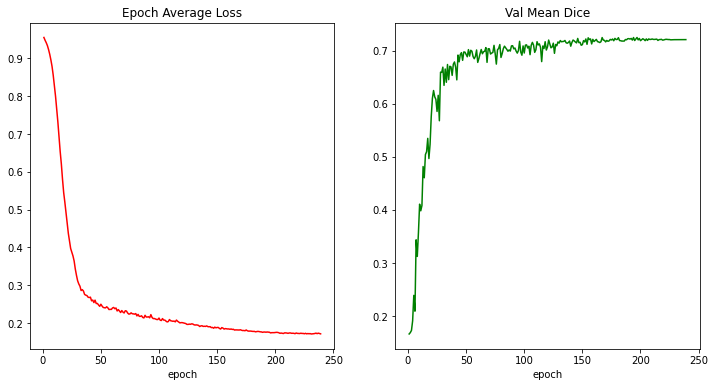

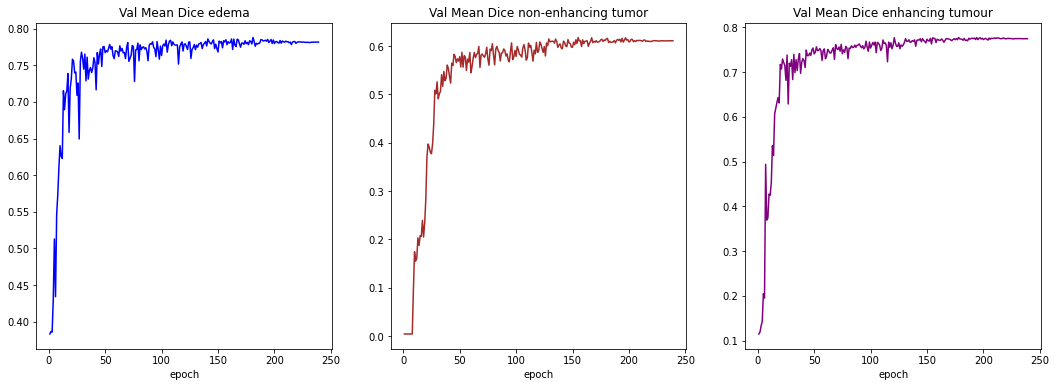

In [162]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()
plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice edema")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice non-enhancing tumor")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice enhancing tumour")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

# Setup test-dataloader

In [63]:
test_files = load_decathlon_datalist(json_list, True, "test")

test_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(
            keys="image", nonzero=True, channel_wise=True
        ),
        EnsureTyped(keys=["image", "label"]),
    ]
)

test_ds = CacheDataset(
    data=test_files,
    transform=test_transform,
    cache_num=8,
    cache_rate=1,
    num_workers=8,
)

test_loader = DataLoader(
    test_ds,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    pin_memory=True,
)

Loading dataset: 100%|██████████| 8/8 [00:01<00:00,  4.62it/s]


# Check best model output with the input image and label

{'image': '/home/jovyan/HK_DV/data/Task01_BrainTumour/imagesTs/BRATS_470.nii.gz', 'label': '/home/jovyan/HK_DV/data/Task01_BrainTumour/labelsTs/BRATS_470.nii.gz'}

Test Image Shape:  torch.Size([4, 240, 240, 155])
True Label Shape: torch.Size([3, 240, 240, 155])
Predicted Image Shape: torch.Size([3, 240, 240, 155])


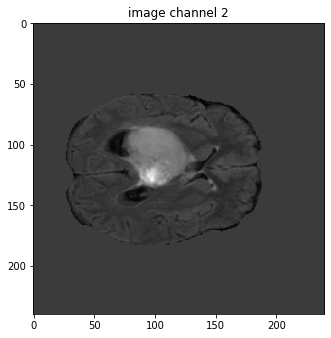

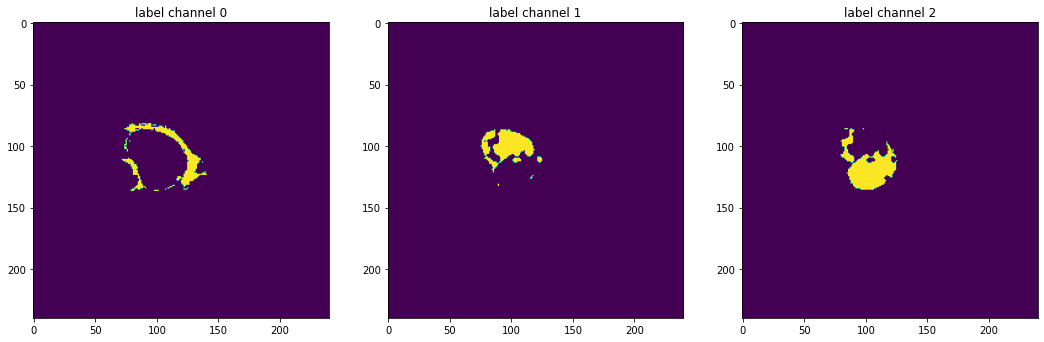

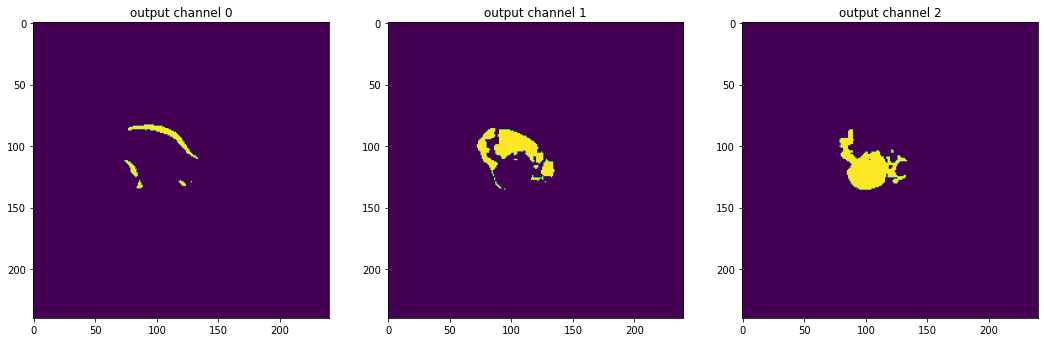

In [102]:
model.load_state_dict(
    torch.load(os.path.join(root_dir, "best_metric_model_new.pth"))
)
model.eval()

with torch.no_grad():
    # select one image to evaluate and visualize the model output
    img_index = 11
    test_input = test_ds[img_index]["image"].unsqueeze(0).to(device)
    print(test_ds.data[img_index])
    print()
    print('Test Image Shape: ',test_ds[img_index]["image"].shape)
    print("True Label Shape:", test_ds[img_index]["label"].shape)
    print("Predicted Image Shape:",test_output.shape)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    test_output = inference(test_input)
    test_output = post_trans(test_output[0])
    
    plt.figure("image", (24, 6))
    plt.subplot(1, 4, 1)
    plt.title(f"image channel {i}")
    plt.imshow(test_ds[img_index]["image"][0, :, :, 80].detach().cpu(), cmap="gray")
    plt.show()
    
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(test_ds[img_index]["label"][i, :, :, 80].detach().cpu())

    plt.show()
    
    # visualize the 3 channels model output corresponding to this image    
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(test_output[i, :, :, 80].detach().cpu())
        
    plt.show()

# Evaluation

In [165]:
test_metric_values = []
test_metric_values_edema = []
test_metric_values_net = []
test_metric_values_et = []


model.eval()
with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = (
            test_data["image"].to(device),
            test_data["label"].to(device),
        )
        test_outputs = inference(test_inputs)
        test_outputs = [post_trans(i) for i in decollate_batch(test_outputs)]
        dice_metric(y_pred=test_outputs, y=test_labels)
        dice_metric_batch(y_pred=test_outputs, y=test_labels)

    metric = dice_metric.aggregate().item()
    test_metric_values.append(metric)
    metric_batch = dice_metric_batch.aggregate()
    metric_ed = metric_batch[0].item()
    test_metric_values_edema.append(metric_ed)
    metric_net = metric_batch[1].item()
    test_metric_values_net.append(metric_net)
    metric_et = metric_batch[2].item()
    test_metric_values_et.append(metric_et)
    dice_metric.reset()
    dice_metric_batch.reset()
    
    print(
        f"test mean dice: {metric:.4f}"
        f" edema: {metric_tc:.4f} non-enhancing tumor: {metric_wt:.4f} enhancing tumour: {metric_et:.4f}"
    )

test mean dice: 0.7133 edema: 0.7851 non-enhancing tumor: 0.5645 enhancing tumour: 0.7901
